# NBA Game Predictions

In [1]:
# Import Libraries
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import sqlite3
from matplotlib import pyplot as plt
import seaborn as sn
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import GroupShuffleSplit 


/Users/kelianneheinz/opt/anaconda3/envs/myvenv/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
run_hyperparameter_tuning = False

# Data Set Up

## Standard Game Stat Dataset PT1 (df_st)
Wyatt Set:
https://www.kaggle.com/datasets/wyattowalsh/basketball

### Load DF

In [3]:
# Create Connection to SQLite DB
con = sqlite3.connect("./Wyatt_NBA_dataset/basketball.sqlite")

# Load in Game table from SQL
df_st = pd.read_sql_query("SELECT * from Game", con)

con.close()

### Select Years, drop some columns
df_st_f1

In [4]:
# Take seasons from 2006 to 2020
df_st_f1 = df_st[(df_st.SEASON.astype('int') >= 2006) & (df_st.SEASON.astype('int') <= 2022)]

In [5]:
# Drop duplicated Game IDs
df_st_f1.drop_duplicates(subset='GAME_ID', keep='first', inplace=True)

### Standardize Team Names
df_st_f2

In [6]:
df_st_f2 = df_st_f1.copy()

In [7]:
# Make Dictionaries of all team name variations

# team_name is full team name
team_name_dict = dict()
for i,j in zip(df_st_f1.TEAM_NAME_HOME, df_st_f1.TEAM_ABBREVIATION_HOME):
    team_name_dict[i] = j

# team nickname is team name - city
team_nickname_dict = dict()
for i,j in zip(df_st_f1.TEAM_ABBREVIATION_HOME, df_st_f1.TEAM_NICKNAME_HOME):
    team_nickname_dict[j] = i

# Team city 
team_city_dict = dict()
for i, j, k in zip(df_st_f1.TEAM_CITY_NAME_HOME, df_st_f1.TEAM_ABBREVIATION_HOME, df_st_f1.TEAM_NAME_HOME):
    if k == "Los Angeles Lakers":
        team_city_dict["L.A. Lakers"] = j
    elif k == "Los Angeles Clippers":
        team_city_dict["L.A. Clippers"] = j
    else:
        team_city_dict[i] = j
team_city_dict['LA Clippers'] = "LAC"

# Alternate abbreviations
team_abbrev_dict = {'CHO':'CHA', 'PHO':'PHX', 'BRK':'BKN', 'NOH':'NOP'}

In [8]:
# Define function to remap column data

def column_remap(df, col_names, map_dict):
    '''Change values in dataframe column based on mapping dictionary'''
    for dict in map_dict:
        for col_name in col_names:
            df[col_name] = df[col_name].map(dict).fillna(df[col_name])

In [9]:
# Standardize team name columns that will be kept
team_name_columns = ['SERIES_LEADER', 'TEAM_ABBREVIATION_HOME',
                     'TEAM_ABBREVIATION_AWAY', 'LAST_GAME_VISITOR_TEAM_CITY1',
                     'LAST_GAME_HOME_TEAM_ABBREVIATION']
team_name_map_dicts = [team_nickname_dict, team_abbrev_dict, team_city_dict]
column_remap(df_st_f2, col_names=team_name_columns, map_dict=team_name_map_dicts)

In [10]:
# Rename team name columns
rename_team_columns = {"LAST_GAME_VISITOR_TEAM_CITY1":"prev_visitor_team",
                       "LAST_GAME_HOME_TEAM_ABBREVIATION":'prev_home_team',
                       "TEAM_ABBREVIATION_HOME":'home_team',
                       "TEAM_ABBREVIATION_AWAY":'away_team'}
df_st_f2.rename(columns=rename_team_columns, inplace=True)

In [11]:
# Drop Extra team Name Related Columns
name_columns = ["TEAM_ID_HOME", "TEAM_CITY_HOME", "TEAM_CITY_AWAY", "TEAM_CITY_NAME_HOME",
                "TEAM_ID_AWAY", "TEAM_ID_HOME", "TEAM_NAME_AWAY", "TEAM_NAME_HOME", "TEAM_NICKNAME_HOME",
                "LAST_GAME_HOME_TEAM_ID", "LAST_GAME_HOME_TEAM_CITY", "LAST_GAME_HOME_TEAM_NAME", "LAST_GAME_VISITOR_TEAM_ID",
                "LAST_GAME_VISITOR_TEAM_CITY", "LAST_GAME_VISITOR_TEAM_NAME"]
df_st_f2 = df_st_f2.drop(columns=name_columns)

## 538 ELO Set
df_elo

Data set from: https://www.kaggle.com/datasets/fivethirtyeight/fivethirtyeight-nba-elo-dataset?select=README.md

In [12]:
# Load in Data
df_elo = pd.read_csv("./nba_elo.csv")

In [13]:
# Check Columns
df_elo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72043 entries, 0 to 72042
Data columns (total 27 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date            72043 non-null  object 
 1   season          72043 non-null  int64  
 2   neutral         72043 non-null  int64  
 3   playoff         4630 non-null   object 
 4   team1           72043 non-null  object 
 5   team2           72043 non-null  object 
 6   elo1_pre        72043 non-null  float64
 7   elo2_pre        72043 non-null  float64
 8   elo_prob1       72043 non-null  float64
 9   elo_prob2       72043 non-null  float64
 10  elo1_post       72043 non-null  float64
 11  elo2_post       72043 non-null  float64
 12  carm-elo1_pre   5249 non-null   float64
 13  carm-elo2_pre   5249 non-null   float64
 14  carm-elo_prob1  5249 non-null   float64
 15  carm-elo_prob2  5249 non-null   float64
 16  carm-elo1_post  5249 non-null   float64
 17  carm-elo2_post  5249 non-null  

In [14]:
# Original columns
df_elo.columns

Index(['date', 'season', 'neutral', 'playoff', 'team1', 'team2', 'elo1_pre',
       'elo2_pre', 'elo_prob1', 'elo_prob2', 'elo1_post', 'elo2_post',
       'carm-elo1_pre', 'carm-elo2_pre', 'carm-elo_prob1', 'carm-elo_prob2',
       'carm-elo1_post', 'carm-elo2_post', 'raptor1_pre', 'raptor2_pre',
       'raptor_prob1', 'raptor_prob2', 'score1', 'score2', 'quality',
       'importance', 'total_rating'],
      dtype='object')

In [15]:
# Drop post game stats
df_elo_f1 = df_elo.drop(columns=['elo_prob1', 'elo_prob1', 'elo1_post', 'elo2_post',
                                 'carm-elo_prob1', 'carm-elo_prob2', 'carm-elo1_post',
                                 'carm-elo2_post', 'quality', 'importance', 'total_rating',
                                 'raptor_prob1', 'raptor_prob2', 'carm-elo1_pre', 'carm-elo2_pre',
                                 'raptor1_pre', 'raptor2_pre', 'elo_prob2'])

In [16]:
# Set year range 
years_filter = range(2009,2020)
df_elo_f2 = df_elo_f1[df_elo_f1.season.astype('int').isin(years_filter)]

In [17]:
# Standardize Team names to abbreviations
team_name_map_dicts = [team_nickname_dict, team_abbrev_dict, team_city_dict]
column_remap(df_elo_f2, ['team1', 'team2'], team_name_map_dicts)

In [18]:
# Get rid of playoff games
df_elo_f2 = df_elo_f2[df_elo_f2.playoff.isna()].drop(columns=['playoff','neutral'])

### Add Join Column to ELO DF (match to Season Rankings DF)
df_elo_f2

In [19]:
# Make Join Column
df_elo_f2['team1_join_date'] = df_elo_f2['team1'] + df_elo_f2['date']
df_elo_f2['team2_join_date'] = df_elo_f2['team2'] + df_elo_f2['date']
df_elo_f2['team1_win'] = np.where(df_elo_f2['score1'] > df_elo_f2['score2'], 1, 0)
df_elo_f3 = df_elo_f2.drop(columns=['score1', 'score2'])

In [20]:
df_elo_f3.head()

,date,season,team1,team2,elo1_pre,elo2_pre,team1_join_date,team2_join_date,team1_win
54201,2008-10-28,2009,LAL,POR,1651.7117,1472.9480,LAL2008-10-28,POR2008-10-28,1
54202,2008-10-28,2009,CHI,MIL,1450.1299,1335.4137,CHI2008-10-28,MIL2008-10-28,1
54203,2008-10-28,2009,BOS,CLE,1667.4963,1547.7573,BOS2008-10-28,CLE2008-10-28,1
54204,2008-10-29,2009,NYK,MIA,1359.4448,1320.1884,NYK2008-10-29,MIA2008-10-29,1
54205,2008-10-29,2009,ORL,ATL,1590.5756,1479.3201,ORL2008-10-29,ATL2008-10-29,0


## Season Rankings Data Set

Link: https://www.kaggle.com/datasets/nathanlauga/nba-games?select=ranking.csv

df_rank

In [21]:
# Load
df_rank = pd.read_csv('./NL_nbaset/ranking.csv')

In [22]:
# Filter down dates
years_filter = range(2008, 2020)
df_rank['year'] = df_rank.STANDINGSDATE.str[0:4].astype('int')
df_rank = df_rank[df_rank.year.isin(years_filter)].drop(columns=['year'])

In [23]:
# Standardize Team names to abbreviations
team_name_map_dicts = [team_nickname_dict, team_abbrev_dict, team_city_dict]
column_remap(df_rank, ['TEAM'], team_name_map_dicts)

In [24]:
# Standings are at end of day - games played that day are included
df_rank[df_rank.STANDINGSDATE.isin(['2019-04-10', '2019-04-09'])]
# Set Join Date to be the day before the standings date
df_rank['join_date'] = pd.to_datetime(df_rank['STANDINGSDATE']) 
df_rank['join_date'] = df_rank['join_date'] + pd.DateOffset(days=1)

In [25]:
# Join Column
df_rank['join_col'] = df_rank['TEAM'] + df_rank['join_date'].astype('str')

In [26]:
# Break up Home records
record = df_rank.HOME_RECORD.str.split("-")
df_rank['home_wins'] = [item[0] for item in record]
df_rank['home_losses'] = [item[1] for item in record]

# Break up Away records
record = df_rank.ROAD_RECORD.str.split("-")
df_rank['away_wins'] = [item[0] for item in record]
df_rank['away_losses'] = [item[1] for item in record]

In [27]:
# Drop Excess columns
df_rank_f1 = df_rank.drop(columns=['ROAD_RECORD', 'RETURNTOPLAY', 'SEASON_ID',
                                             'HOME_RECORD', 'LEAGUE_ID', 'TEAM_ID', 'join_date',
                                             'STANDINGSDATE', 'TEAM', 'CONFERENCE'])

In [28]:
df_rank_f1.head()

,G,W,L,W_PCT,join_col,home_wins,home_losses,away_wins,away_losses
24074,33,26,7,0.788,LAL2020-01-01,11,4,15,3
24075,33,23,10,0.697,DEN2020-01-01,15,4,8,6
24076,35,24,11,0.686,LAC2020-01-01,14,3,10,8
24077,34,23,11,0.676,HOU2020-01-01,12,4,11,7
24078,33,21,12,0.636,DAL2020-01-01,9,7,12,5


## Combining ELO with season Standing Stats

### Merge df_elo_f2 and df_rank_f1
df_merge1

In [29]:
# Merge Data Frames
df_merge1 = df_elo_f2.merge(df_rank_f1, how='left', left_on='team1_join_date', right_on='join_col')
df_merge1 = df_merge1.merge(df_rank_f1, how='left', left_on='team2_join_date', right_on='join_col', suffixes=("_team1","_team2"))
df_merge1.drop(columns=['team1_join_date', 'team2_join_date', 'join_col_team1',
                        'join_col_team2', 'score1', 'score2'], inplace=True)
df_merge1.head()

,date,season,team1,team2,elo1_pre,elo2_pre,team1_win,G_team1,W_team1,L_team1,...,away_wins_team1,away_losses_team1,G_team2,W_team2,L_team2,W_PCT_team2,home_wins_team2,home_losses_team2,away_wins_team2,away_losses_team2
0,2008-10-28,2009,LAL,POR,1651.7117,1472.9480,1,8,6,2,...,0,0,7,4,3,0.571,2,2,2,1
1,2008-10-28,2009,CHI,MIL,1450.1299,1335.4137,1,8,4,4,...,2,1,8,1,7,0.125,1,3,0,4
2,2008-10-28,2009,BOS,CLE,1667.4963,1547.7573,1,8,6,2,...,3,1,8,3,5,0.375,2,3,1,2
3,2008-10-29,2009,NYK,MIA,1359.4448,1320.1884,1,0,0,0,...,0,0,0,0,0,0.000,0,0,0,0
4,2008-10-29,2009,ORL,ATL,1590.5756,1479.3201,0,0,0,0,...,0,0,0,0,0,0.000,0,0,0,0


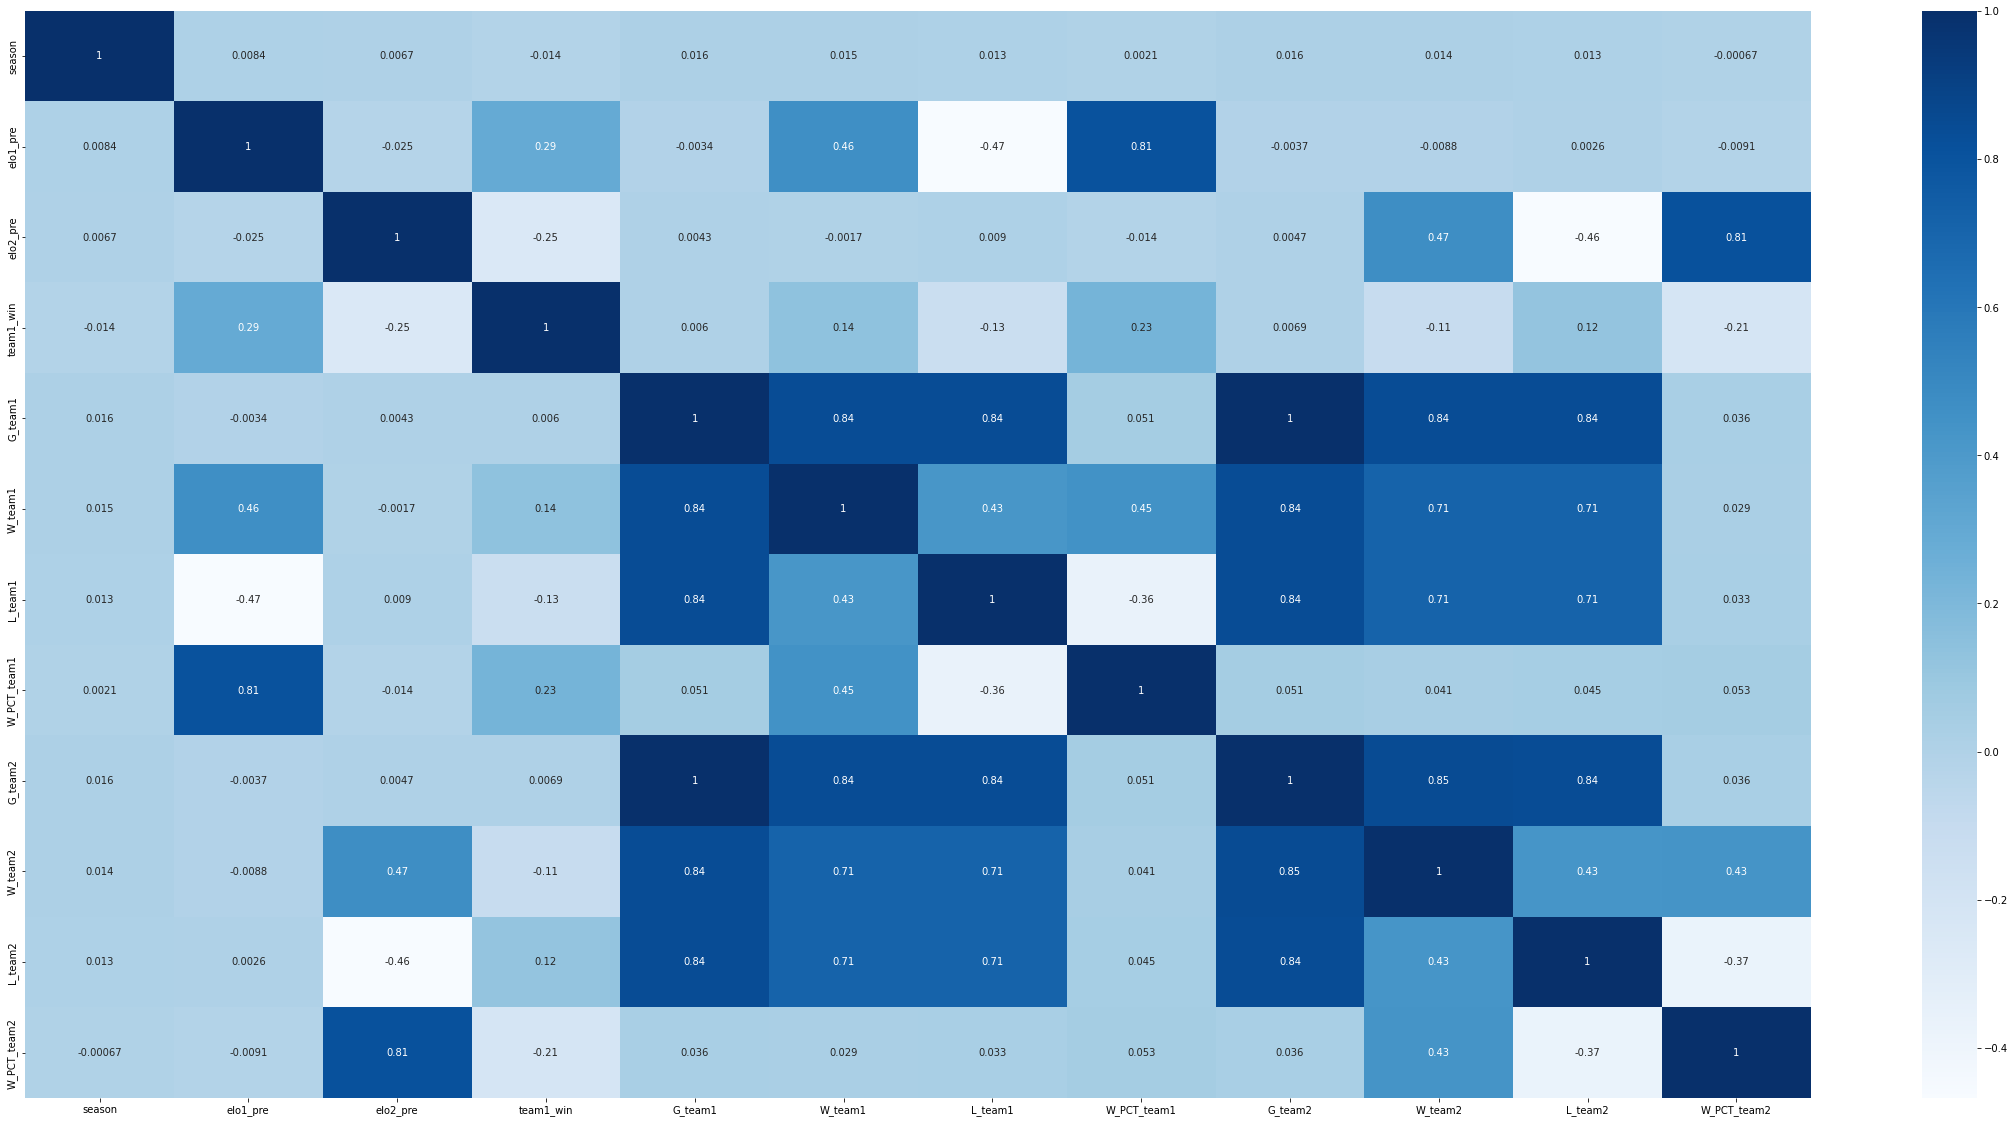

In [30]:
# Correlation Map
df_corr = df_merge1.drop(columns=['team1', 'team2']).corr()
plt.figure(figsize=(40,20))
sn.heatmap(df_corr, annot=True, cmap="Blues")
plt.show()

## Merge Last Game Key to first Merge

### Make Key

In [31]:
df_key = df_st_f2[['home_team', 'away_team', 'GAME_DATE',
                    'GAME_ID', 'LAST_GAME_ID']].copy()

In [32]:
df_key['team1'] = np.where(df_key.home_team < df_key.away_team, df_key.home_team, df_key.away_team)
df_key['team2'] = np.where(df_key.home_team < df_key.away_team, df_key.away_team, df_key.home_team)
df_key['matchup'] = df_key.team1 + df_key.team2
df_key['join_key'] = (df_key.GAME_DATE.astype('str').replace("-", "", regex=True) + "/" + df_key.matchup)
df_key2 = df_key.drop(columns=['home_team', 'away_team'])
df_key2.sort_values(by=['matchup', 'GAME_DATE'], inplace=True)
df_key2.head()

,GAME_DATE,GAME_ID,LAST_GAME_ID,team1,team2,matchup,join_key
52208,2013-01-16,0021200572,0021100703,ATL,BKN,ATLBKN,20130116/ATLBKN
52218,2013-01-18,0021200588,0021200572,ATL,BKN,ATLBKN,20130118/ATLBKN
52563,2013-03-09,0021200927,0021200588,ATL,BKN,ATLBKN,20130309/ATLBKN
52619,2013-03-17,0021200991,0021200927,ATL,BKN,ATLBKN,20130317/ATLBKN
53383,2014-01-06,0021300506,0021200991,ATL,BKN,ATLBKN,20140106/ATLBKN


In [33]:
key_count_dict = df_key2.matchup.value_counts().to_dict()
prev_game_array = []
game_array = []
for value in sorted(key_count_dict.keys()):
    for i in list(range(0,key_count_dict[value])):
        prev_game_array.append(value+str(i))
        game_array.append(value+str(i+1))

In [34]:
df_key2['prev_game_id'] = np.array(prev_game_array)
df_key2['game_id'] = np.array(game_array)
df_key3 = df_key2[['GAME_ID', 'game_id', 'prev_game_id', 'join_key']].copy()

In [35]:
df_key3.head()

,GAME_ID,game_id,prev_game_id,join_key
52208,0021200572,ATLBKN1,ATLBKN0,20130116/ATLBKN
52218,0021200588,ATLBKN2,ATLBKN1,20130118/ATLBKN
52563,0021200927,ATLBKN3,ATLBKN2,20130309/ATLBKN
52619,0021200991,ATLBKN4,ATLBKN3,20130317/ATLBKN
53383,0021300506,ATLBKN5,ATLBKN4,20140106/ATLBKN


### Adding keys first merge data

In [36]:
df_merge2 = df_merge1.copy()

# Make key to join on
df_merge2['join_key'] = np.where(df_merge2.team1 < df_merge2.team2,
    (df_merge2.date.astype('str').replace("-","", regex=True)+ "/" + df_merge2.team1 + df_merge2.team2),
    (df_merge2.date.astype('str').replace("-","", regex=True)+ "/" + df_merge2.team2 + df_merge2.team1))

df_merge3 = df_merge2.merge(df_key3, how='left', on='join_key')
df_merge3.head()

,date,season,team1,team2,elo1_pre,elo2_pre,team1_win,G_team1,W_team1,L_team1,...,L_team2,W_PCT_team2,home_wins_team2,home_losses_team2,away_wins_team2,away_losses_team2,join_key,GAME_ID,game_id,prev_game_id
0,2008-10-28,2009,LAL,POR,1651.7117,1472.9480,1,8,6,2,...,3,0.571,2,2,2,1,20081028/LALPOR,0020800003,LALPOR8,LALPOR7
1,2008-10-28,2009,CHI,MIL,1450.1299,1335.4137,1,8,4,4,...,7,0.125,1,3,0,4,20081028/CHIMIL,0020800002,CHIMIL9,CHIMIL8
2,2008-10-28,2009,BOS,CLE,1667.4963,1547.7573,1,8,6,2,...,5,0.375,2,3,1,2,20081028/BOSCLE,0020800001,BOSCLE8,BOSCLE7
3,2008-10-29,2009,NYK,MIA,1359.4448,1320.1884,1,0,0,0,...,0,0.000,0,0,0,0,20081029/MIANYK,0020800007,MIANYK9,MIANYK8
4,2008-10-29,2009,ORL,ATL,1590.5756,1479.3201,0,0,0,0,...,0,0.000,0,0,0,0,20081029/ATLORL,0020800004,ATLORL9,ATLORL8


In [37]:
# Check that no more NAs remain
df_merge3[df_merge3.game_id.isna()]

,date,season,team1,team2,elo1_pre,elo2_pre,team1_win,G_team1,W_team1,L_team1,...,L_team2,W_PCT_team2,home_wins_team2,home_losses_team2,away_wins_team2,away_losses_team2,join_key,GAME_ID,game_id,prev_game_id


## Standard Game Set Preparation

### Prepare Columns to Merge from Standard Game Data
df_st_f3

In [38]:
# Try to add to df_st_f3
home_team_cols_to_merge = ['home_team', 'FGM_HOME', 'FGA_HOME', 'FG_PCT_HOME',
                            'FG3M_HOME', 'FG3A_HOME', 'FG3_PCT_HOME', 'FTM_HOME', 'FTA_HOME',
                            'FT_PCT_HOME', 'OREB_HOME', 'DREB_HOME','REB_HOME', 'AST_HOME', 'STL_HOME', 'BLK_HOME',
                            'TOV_HOME', 'PF_HOME', 'PTS_HOME', 'PLUS_MINUS_HOME', 'PTS_PAINT_HOME',
                            'PTS_2ND_CHANCE_HOME', 'PTS_FB_HOME', 'LARGEST_LEAD_HOME', 'LEAD_CHANGES_HOME',
                            'TIMES_TIED_HOME', 'TEAM_TURNOVERS_HOME','TOTAL_TURNOVERS_HOME', 'TEAM_REBOUNDS_HOME',
                            'PTS_OFF_TO_HOME', 'LAST_GAME_HOME_TEAM_POINTS']

away_team_cols_to_merge = ['away_team', 'FGM_AWAY', 'FGA_AWAY', 'FG_PCT_AWAY',
                            'FG3M_AWAY', 'FG3A_AWAY', 'FG3_PCT_AWAY', 'FTM_AWAY', 'FTA_AWAY',
                            'FT_PCT_AWAY', 'OREB_AWAY', 'DREB_AWAY', 'REB_AWAY', 'AST_AWAY', 'STL_AWAY', 'BLK_AWAY',
                            'TOV_AWAY', 'PF_AWAY', 'PTS_AWAY', 'PLUS_MINUS_AWAY', 'PTS_PAINT_AWAY',
                            'PTS_2ND_CHANCE_AWAY', 'PTS_FB_AWAY', 'LARGEST_LEAD_AWAY', 'LEAD_CHANGES_AWAY',
                            'TIMES_TIED_AWAY', 'TEAM_TURNOVERS_AWAY', 'TOTAL_TURNOVERS_AWAY', 'TEAM_REBOUNDS_AWAY',
                            'PTS_OFF_TO_AWAY', 'LAST_GAME_VISITOR_TEAM_POINTS']

game_detail_cols_to_merge = ['GAME_ID', 'SERIES_LEADER']

cols_to_merge = game_detail_cols_to_merge + home_team_cols_to_merge + away_team_cols_to_merge
df_st_f3 = df_st_f2[cols_to_merge].copy()

In [39]:
df_st_f3.head()

,GAME_ID,SERIES_LEADER,home_team,FGM_HOME,FGA_HOME,FG_PCT_HOME,FG3M_HOME,FG3A_HOME,FG3_PCT_HOME,FTM_HOME,...,PTS_2ND_CHANCE_AWAY,PTS_FB_AWAY,LARGEST_LEAD_AWAY,LEAD_CHANGES_AWAY,TIMES_TIED_AWAY,TEAM_TURNOVERS_AWAY,TOTAL_TURNOVERS_AWAY,TEAM_REBOUNDS_AWAY,PTS_OFF_TO_AWAY,LAST_GAME_VISITOR_TEAM_POINTS
44493,0020600002,PHX,LAL,46.0,83,0.554,6,12,0.500,16.0,...,8,20,19,10,5,0,21,6,31,91
44494,0020600001,CHI,MIA,25.0,65,0.385,3,17,0.176,13.0,...,18,21,42,2,3,0,16,11,15,96
44495,0020600005,ORL,ORL,35.0,59,0.593,6,8,0.750,33.0,...,11,9,1,1,0,0,15,14,22,116
44496,0020600014,Tied,PHX,41.0,77,0.532,4,15,0.267,26.0,...,22,2,7,1,3,0,14,8,20,107
44497,0020600011,Tied,MIN,35.0,72,0.486,4,9,0.444,18.0,...,34,4,7,8,9,0,18,9,20,89


### Merge Join Key To standard data set

In [40]:
df_st_f4 = df_st_f3.merge(df_key2, how='left', left_on='GAME_ID', right_on='GAME_ID')

In [41]:
df_st_f4.drop(columns=['GAME_ID', 'LAST_GAME_ID', 'team1', 'team2', 'join_key', 'matchup'], inplace=True)

In [42]:
df_st_f4.columns

Index(['SERIES_LEADER', 'home_team', 'FGM_HOME', 'FGA_HOME', 'FG_PCT_HOME',
       'FG3M_HOME', 'FG3A_HOME', 'FG3_PCT_HOME', 'FTM_HOME', 'FTA_HOME',
       'FT_PCT_HOME', 'OREB_HOME', 'DREB_HOME', 'REB_HOME', 'AST_HOME',
       'STL_HOME', 'BLK_HOME', 'TOV_HOME', 'PF_HOME', 'PTS_HOME',
       'PLUS_MINUS_HOME', 'PTS_PAINT_HOME', 'PTS_2ND_CHANCE_HOME',
       'PTS_FB_HOME', 'LARGEST_LEAD_HOME', 'LEAD_CHANGES_HOME',
       'TIMES_TIED_HOME', 'TEAM_TURNOVERS_HOME', 'TOTAL_TURNOVERS_HOME',
       'TEAM_REBOUNDS_HOME', 'PTS_OFF_TO_HOME', 'LAST_GAME_HOME_TEAM_POINTS',
       'away_team', 'FGM_AWAY', 'FGA_AWAY', 'FG_PCT_AWAY', 'FG3M_AWAY',
       'FG3A_AWAY', 'FG3_PCT_AWAY', 'FTM_AWAY', 'FTA_AWAY', 'FT_PCT_AWAY',
       'OREB_AWAY', 'DREB_AWAY', 'REB_AWAY', 'AST_AWAY', 'STL_AWAY',
       'BLK_AWAY', 'TOV_AWAY', 'PF_AWAY', 'PTS_AWAY', 'PLUS_MINUS_AWAY',
       'PTS_PAINT_AWAY', 'PTS_2ND_CHANCE_AWAY', 'PTS_FB_AWAY',
       'LARGEST_LEAD_AWAY', 'LEAD_CHANGES_AWAY', 'TIMES_TIED_AWAY',
       'TEA

In [43]:
df_merge3.columns

Index(['date', 'season', 'team1', 'team2', 'elo1_pre', 'elo2_pre', 'team1_win',
       'G_team1', 'W_team1', 'L_team1', 'W_PCT_team1', 'home_wins_team1',
       'home_losses_team1', 'away_wins_team1', 'away_losses_team1', 'G_team2',
       'W_team2', 'L_team2', 'W_PCT_team2', 'home_wins_team2',
       'home_losses_team2', 'away_wins_team2', 'away_losses_team2', 'join_key',
       'GAME_ID', 'game_id', 'prev_game_id'],
      dtype='object')

In [44]:
df_merge4 = df_merge3.merge(df_st_f4, how='left', left_on='prev_game_id', right_on='game_id')
df_merge5 = df_merge4[['date', 'season', 'team1', 'team2', 'elo1_pre', 'elo2_pre', 'team1_win',
       'G_team1', 'W_team1', 'L_team1', 'W_PCT_team1', 'home_wins_team1',
       'home_losses_team1', 'away_wins_team1', 'away_losses_team1', 'G_team2',
       'W_team2', 'L_team2', 'W_PCT_team2', 'home_wins_team2',
       'home_losses_team2', 'away_wins_team2', 'away_losses_team2',
       'SERIES_LEADER', 'home_team',
       'FGM_HOME', 'FGA_HOME', 'FG_PCT_HOME', 'FG3M_HOME', 'FG3A_HOME',
       'FG3_PCT_HOME', 'FTM_HOME', 'FTA_HOME', 'FT_PCT_HOME', 'OREB_HOME',
       'DREB_HOME', 'REB_HOME', 'AST_HOME', 'STL_HOME', 'BLK_HOME', 'TOV_HOME',
       'PF_HOME', 'PTS_HOME', 'PLUS_MINUS_HOME', 'PTS_PAINT_HOME',
       'PTS_2ND_CHANCE_HOME', 'PTS_FB_HOME', 'LARGEST_LEAD_HOME',
       'LEAD_CHANGES_HOME', 'TIMES_TIED_HOME', 'TEAM_TURNOVERS_HOME',
       'TOTAL_TURNOVERS_HOME', 'TEAM_REBOUNDS_HOME', 'PTS_OFF_TO_HOME',
       'LAST_GAME_HOME_TEAM_POINTS', 'away_team', 'FGM_AWAY', 'FGA_AWAY',
       'FG_PCT_AWAY', 'FG3M_AWAY', 'FG3A_AWAY', 'FG3_PCT_AWAY', 'FTM_AWAY',
       'FTA_AWAY', 'FT_PCT_AWAY', 'OREB_AWAY', 'DREB_AWAY', 'REB_AWAY',
       'AST_AWAY', 'STL_AWAY', 'BLK_AWAY', 'TOV_AWAY', 'PF_AWAY', 'PTS_AWAY',
       'PLUS_MINUS_AWAY', 'PTS_PAINT_AWAY', 'PTS_2ND_CHANCE_AWAY',
       'PTS_FB_AWAY', 'LARGEST_LEAD_AWAY', 'LEAD_CHANGES_AWAY',
       'TIMES_TIED_AWAY', 'TEAM_TURNOVERS_AWAY', 'TOTAL_TURNOVERS_AWAY',
       'TEAM_REBOUNDS_AWAY', 'PTS_OFF_TO_AWAY',
       'LAST_GAME_VISITOR_TEAM_POINTS']].copy()
df_merge5.head()

,date,season,team1,team2,elo1_pre,elo2_pre,team1_win,G_team1,W_team1,L_team1,...,PTS_2ND_CHANCE_AWAY,PTS_FB_AWAY,LARGEST_LEAD_AWAY,LEAD_CHANGES_AWAY,TIMES_TIED_AWAY,TEAM_TURNOVERS_AWAY,TOTAL_TURNOVERS_AWAY,TEAM_REBOUNDS_AWAY,PTS_OFF_TO_AWAY,LAST_GAME_VISITOR_TEAM_POINTS
0,2008-10-28,2009,LAL,POR,1651.7117,1472.9480,1,8,6,2,...,17,5,1,12,5,0,11,7,11,104
1,2008-10-28,2009,CHI,MIL,1450.1299,1335.4137,1,8,4,4,...,8,20,26,1,2,0,10,3,13,114
2,2008-10-28,2009,BOS,CLE,1667.4963,1547.7573,1,8,6,2,...,15,8,2,1,2,2,17,7,21,114
3,2008-10-29,2009,NYK,MIA,1359.4448,1320.1884,1,0,0,0,...,6,9,3,8,10,1,11,9,10,88
4,2008-10-29,2009,ORL,ATL,1590.5756,1479.3201,0,0,0,0,...,11,18,20,6,8,0,12,5,17,90


In [45]:
df_merge6 = df_merge5.copy()

In [46]:
## Put game stats in terms of team1 and team2
# if df_full_f1.team1 == df_full_f1.home_team:
df_merge6['pgame_team1_home'] = np.where(df_merge6.team1 == df_merge6.home_team, 1, 0)
df_merge6['FGM_team1'] = np.where(df_merge6.team1 == df_merge6.home_team, df_merge6.FGM_HOME, df_merge6.FGM_AWAY)
df_merge6['FGA_team1'] = np.where(df_merge6.team1 == df_merge6.home_team, df_merge6.FGA_HOME, df_merge6.FGA_AWAY)
df_merge6['FG_PCT_team1'] = np.where(df_merge6.team1 == df_merge6.home_team, df_merge6.FG_PCT_HOME, df_merge6.FG_PCT_AWAY)
df_merge6['FG3M_team1'] = np.where(df_merge6.team1 == df_merge6.home_team, df_merge6.FG3M_HOME, df_merge6.FG3M_AWAY)
df_merge6['FG3A_team1'] = np.where(df_merge6.team1 == df_merge6.home_team, df_merge6.FG3A_HOME, df_merge6.FG3A_AWAY)
df_merge6['FG3_PCT_team1'] = np.where(df_merge6.team1 == df_merge6.home_team, df_merge6.FG3_PCT_HOME, df_merge6.FG3_PCT_AWAY)
df_merge6['FTM_team1'] = np.where(df_merge6.team1 == df_merge6.home_team, df_merge6.FTM_HOME, df_merge6.FTM_AWAY)
df_merge6['FTA_team1'] = np.where(df_merge6.team1 == df_merge6.home_team, df_merge6.FTA_HOME, df_merge6.FTA_AWAY)
df_merge6['FT_PCT_team1'] = np.where(df_merge6.team1 == df_merge6.home_team, df_merge6.FT_PCT_HOME, df_merge6.FT_PCT_AWAY)
df_merge6['OREB_team1'] = np.where(df_merge6.team1 == df_merge6.home_team, df_merge6.OREB_HOME, df_merge6.OREB_AWAY)
df_merge6['DREB_team1'] = np.where(df_merge6.team1 == df_merge6.home_team, df_merge6.DREB_HOME, df_merge6.DREB_AWAY)
df_merge6['REB_team1'] = np.where(df_merge6.team1 == df_merge6.home_team, df_merge6.REB_HOME, df_merge6.REB_AWAY)
df_merge6['AST_team1'] = np.where(df_merge6.team1 == df_merge6.home_team, df_merge6.AST_HOME, df_merge6.AST_AWAY)
df_merge6['STL_team1'] = np.where(df_merge6.team1 == df_merge6.home_team, df_merge6.STL_HOME, df_merge6.STL_AWAY)
df_merge6['BLK_team1'] = np.where(df_merge6.team1 == df_merge6.home_team, df_merge6.BLK_HOME, df_merge6.BLK_AWAY)
df_merge6['TOV_team1'] = np.where(df_merge6.team1 == df_merge6.home_team, df_merge6.TOV_HOME, df_merge6.TOV_AWAY)
df_merge6['PF_team1'] = np.where(df_merge6.team1 == df_merge6.home_team, df_merge6.PF_HOME, df_merge6.PF_AWAY)
df_merge6['PTS_team1'] = np.where(df_merge6.team1 == df_merge6.home_team, df_merge6.PTS_HOME, df_merge6.PTS_AWAY)
df_merge6['PLUS_MINUS_team1'] = np.where(df_merge6.team1 == df_merge6.home_team, df_merge6.PLUS_MINUS_HOME, df_merge6.PLUS_MINUS_AWAY)
df_merge6['PTS_PAINT_team1'] = np.where(df_merge6.team1 == df_merge6.home_team, df_merge6.PTS_PAINT_HOME, df_merge6.PTS_PAINT_AWAY)
df_merge6['PTS_2ND_CHANCE_team1'] = np.where(df_merge6.team1 == df_merge6.home_team, df_merge6.PTS_2ND_CHANCE_HOME, df_merge6.PTS_2ND_CHANCE_AWAY)
df_merge6['PTS_FB_team1'] = np.where(df_merge6.team1 == df_merge6.home_team, df_merge6.PTS_FB_HOME, df_merge6.PTS_FB_AWAY)
df_merge6['LARGEST_LEAD_team1'] = np.where(df_merge6.team1 == df_merge6.home_team, df_merge6.LARGEST_LEAD_HOME, df_merge6.LARGEST_LEAD_AWAY)
df_merge6['LEAD_CHANGES_team1'] = np.where(df_merge6.team1 == df_merge6.home_team, df_merge6.LEAD_CHANGES_HOME, df_merge6.LEAD_CHANGES_AWAY)
df_merge6['TIMES_TIED_team1'] = np.where(df_merge6.team1 == df_merge6.home_team, df_merge6.TIMES_TIED_HOME, df_merge6.TIMES_TIED_AWAY)
df_merge6['TEAM_TURNOVERS_team1'] = np.where(df_merge6.team1 == df_merge6.home_team, df_merge6.TEAM_TURNOVERS_HOME, df_merge6.TEAM_TURNOVERS_AWAY)
df_merge6['TOTAL_TURNOVERS_team1'] = np.where(df_merge6.team1 == df_merge6.home_team, df_merge6.TOTAL_TURNOVERS_HOME, df_merge6.TOTAL_TURNOVERS_AWAY)
df_merge6['TEAM_REBOUNDS_team1'] = np.where(df_merge6.team1 == df_merge6.home_team, df_merge6.TEAM_REBOUNDS_HOME, df_merge6.TEAM_REBOUNDS_AWAY)
df_merge6['PTS_FB_team1'] = np.where(df_merge6.team1 == df_merge6.home_team, df_merge6.PTS_FB_HOME, df_merge6.PTS_FB_AWAY)
df_merge6['PTS_OFF_TO_team1'] = np.where(df_merge6.team1 == df_merge6.home_team, df_merge6.PTS_OFF_TO_HOME, df_merge6.PTS_OFF_TO_AWAY)
df_merge6['LAST_GAME_POINTS_team1'] = np.where(df_merge6.team1 == df_merge6.home_team, df_merge6.LAST_GAME_HOME_TEAM_POINTS, df_merge6.LAST_GAME_VISITOR_TEAM_POINTS)

# if df_full_f1.team2 == df_full_f1.home_team:
df_merge6['pgame_team2_home'] = np.where(df_merge6.team2 == df_merge6.home_team, 1, 0)
df_merge6['FGM_team2'] = np.where(df_merge6.team2 == df_merge6.home_team, df_merge6.FGM_HOME, df_merge6.FGM_AWAY)
df_merge6['FGA_team2'] = np.where(df_merge6.team2 == df_merge6.home_team, df_merge6.FGA_HOME, df_merge6.FGA_AWAY)
df_merge6['FG_PCT_team2'] = np.where(df_merge6.team2 == df_merge6.home_team, df_merge6.FG_PCT_HOME, df_merge6.FG_PCT_AWAY)
df_merge6['FG3M_team2'] = np.where(df_merge6.team2 == df_merge6.home_team, df_merge6.FG3M_HOME, df_merge6.FG3M_AWAY)
df_merge6['FG3A_team2'] = np.where(df_merge6.team2 == df_merge6.home_team, df_merge6.FG3A_HOME, df_merge6.FG3A_AWAY)
df_merge6['FG3_PCT_team2'] = np.where(df_merge6.team2 == df_merge6.home_team, df_merge6.FG3_PCT_HOME, df_merge6.FG3_PCT_AWAY)
df_merge6['FTM_team2'] = np.where(df_merge6.team2 == df_merge6.home_team, df_merge6.FTM_HOME, df_merge6.FTM_AWAY)
df_merge6['FTA_team2'] = np.where(df_merge6.team2 == df_merge6.home_team, df_merge6.FTA_HOME, df_merge6.FTA_AWAY)
df_merge6['FT_PCT_team2'] = np.where(df_merge6.team2 == df_merge6.home_team, df_merge6.FT_PCT_HOME, df_merge6.FT_PCT_AWAY)
df_merge6['OREB_team2'] = np.where(df_merge6.team2 == df_merge6.home_team, df_merge6.OREB_HOME, df_merge6.OREB_AWAY)
df_merge6['DREB_team2'] = np.where(df_merge6.team2 == df_merge6.home_team, df_merge6.DREB_HOME, df_merge6.DREB_AWAY)
df_merge6['REB_team2'] = np.where(df_merge6.team2 == df_merge6.home_team, df_merge6.REB_HOME, df_merge6.REB_AWAY)
df_merge6['AST_team2'] = np.where(df_merge6.team2 == df_merge6.home_team, df_merge6.AST_HOME, df_merge6.AST_AWAY)
df_merge6['STL_team2'] = np.where(df_merge6.team2 == df_merge6.home_team, df_merge6.STL_HOME, df_merge6.STL_AWAY)
df_merge6['BLK_team2'] = np.where(df_merge6.team2 == df_merge6.home_team, df_merge6.BLK_HOME, df_merge6.BLK_AWAY)
df_merge6['TOV_team2'] = np.where(df_merge6.team2 == df_merge6.home_team, df_merge6.TOV_HOME, df_merge6.TOV_AWAY)
df_merge6['PF_team2'] = np.where(df_merge6.team2 == df_merge6.home_team, df_merge6.PF_HOME, df_merge6.PF_AWAY)
df_merge6['PTS_team2'] = np.where(df_merge6.team2 == df_merge6.home_team, df_merge6.PTS_HOME, df_merge6.PTS_AWAY)
df_merge6['PLUS_MINUS_team2'] = np.where(df_merge6.team2 == df_merge6.home_team, df_merge6.PLUS_MINUS_HOME, df_merge6.PLUS_MINUS_AWAY)
df_merge6['PTS_PAINT_team2'] = np.where(df_merge6.team2 == df_merge6.home_team, df_merge6.PTS_PAINT_HOME, df_merge6.PTS_PAINT_AWAY)
df_merge6['PTS_2ND_CHANCE_team2'] = np.where(df_merge6.team2 == df_merge6.home_team, df_merge6.PTS_2ND_CHANCE_HOME, df_merge6.PTS_2ND_CHANCE_AWAY)
df_merge6['PTS_FB_team2'] = np.where(df_merge6.team2 == df_merge6.home_team, df_merge6.PTS_FB_HOME, df_merge6.PTS_FB_AWAY)
df_merge6['LARGEST_LEAD_team2'] = np.where(df_merge6.team2 == df_merge6.home_team, df_merge6.LARGEST_LEAD_HOME, df_merge6.LARGEST_LEAD_AWAY)
df_merge6['LEAD_CHANGES_team2'] = np.where(df_merge6.team2 == df_merge6.home_team, df_merge6.LEAD_CHANGES_HOME, df_merge6.LEAD_CHANGES_AWAY)
df_merge6['TIMES_TIED_team2'] = np.where(df_merge6.team2 == df_merge6.home_team, df_merge6.TIMES_TIED_HOME, df_merge6.TIMES_TIED_AWAY)
df_merge6['TEAM_TURNOVERS_team2'] = np.where(df_merge6.team2 == df_merge6.home_team, df_merge6.TEAM_TURNOVERS_HOME, df_merge6.TEAM_TURNOVERS_AWAY)
df_merge6['TOTAL_TURNOVERS_team2'] = np.where(df_merge6.team2 == df_merge6.home_team, df_merge6.TOTAL_TURNOVERS_HOME, df_merge6.TOTAL_TURNOVERS_AWAY)
df_merge6['TEAM_REBOUNDS_team2'] = np.where(df_merge6.team2 == df_merge6.home_team, df_merge6.TEAM_REBOUNDS_HOME, df_merge6.TEAM_REBOUNDS_AWAY)
df_merge6['LAST_GAME_POINTS_team2'] = np.where(df_merge6.team2 == df_merge6.home_team, df_merge6.LAST_GAME_HOME_TEAM_POINTS, df_merge6.LAST_GAME_VISITOR_TEAM_POINTS)
df_merge6['PTS_FB_team2'] = np.where(df_merge6.team2 == df_merge6.home_team, df_merge6.PTS_FB_HOME, df_merge6.PTS_FB_AWAY)
df_merge6['PTS_OFF_TO_team2'] = np.where(df_merge6.team2 == df_merge6.home_team, df_merge6.PTS_OFF_TO_HOME, df_merge6.PTS_OFF_TO_AWAY)

df_full = df_merge6.drop(columns=['home_team', 'FGM_HOME', 'FGA_HOME', 'FG_PCT_HOME', 'FG3M_HOME',
       'FG3A_HOME', 'FG3_PCT_HOME', 'FTM_HOME', 'FTA_HOME', 'FT_PCT_HOME',
       'OREB_HOME', 'DREB_HOME', 'REB_HOME', 'AST_HOME', 'STL_HOME',
       'BLK_HOME', 'TOV_HOME', 'PTS_HOME', 'PLUS_MINUS_HOME', 'PTS_PAINT_HOME',
       'PTS_2ND_CHANCE_HOME', 'PTS_FB_HOME', 'LARGEST_LEAD_HOME',
       'LEAD_CHANGES_HOME', 'TIMES_TIED_HOME', 'TOTAL_TURNOVERS_HOME',
       'LAST_GAME_HOME_TEAM_POINTS', 'away_team', 'FGM_AWAY',
       'FGA_AWAY', 'FG_PCT_AWAY', 'FG3M_AWAY', 'FG3A_AWAY', 'FG3_PCT_AWAY',
       'FTM_AWAY', 'FTA_AWAY', 'FT_PCT_AWAY', 'OREB_AWAY', 'DREB_AWAY',
       'REB_AWAY', 'AST_HOME', 'AST_AWAY', 'STL_AWAY', 'BLK_AWAY', 'TOV_AWAY', 'PTS_AWAY',
       'PLUS_MINUS_AWAY', 'PTS_PAINT_AWAY', 'PTS_2ND_CHANCE_AWAY',
       'PTS_FB_AWAY', 'LARGEST_LEAD_AWAY', 'LEAD_CHANGES_AWAY',
       'TIMES_TIED_AWAY', 'TOTAL_TURNOVERS_AWAY',
       'LAST_GAME_VISITOR_TEAM_POINTS',  'PTS_FB_HOME', 'PTS_OFF_TO_HOME',
       'PTS_OFF_TO_AWAY', 'PTS_FB_AWAY', 'PF_HOME', 'PF_AWAY', 'TEAM_TURNOVERS_AWAY', 'TEAM_TURNOVERS_HOME',
       'TEAM_REBOUNDS_HOME', 'TEAM_REBOUNDS_AWAY'])


### Fill NA Values with mean for the column

These nulls are the result of newly formed teams playing each opponent for the first time, meaning there is no data for previous matchup stats. These will be replaced with the avg value for each stat.

In [47]:
# Find columns with NA values
for i in df_full.columns:
    empty = df_full[i].isna().sum()
    if empty != 0:
        print(i)

SERIES_LEADER
FGM_team1
FGA_team1
FG_PCT_team1
FG3M_team1
FG3A_team1
FG3_PCT_team1
FTM_team1
FTA_team1
FT_PCT_team1
OREB_team1
DREB_team1
REB_team1
AST_team1
STL_team1
BLK_team1
TOV_team1
PF_team1
PTS_team1
PLUS_MINUS_team1
PTS_PAINT_team1
PTS_2ND_CHANCE_team1
PTS_FB_team1
LARGEST_LEAD_team1
LEAD_CHANGES_team1
TIMES_TIED_team1
TEAM_TURNOVERS_team1
TOTAL_TURNOVERS_team1
TEAM_REBOUNDS_team1
PTS_OFF_TO_team1
LAST_GAME_POINTS_team1
FGM_team2
FGA_team2
FG_PCT_team2
FG3M_team2
FG3A_team2
FG3_PCT_team2
FTM_team2
FTA_team2
FT_PCT_team2
OREB_team2
DREB_team2
REB_team2
AST_team2
STL_team2
BLK_team2
TOV_team2
PF_team2
PTS_team2
PLUS_MINUS_team2
PTS_PAINT_team2
PTS_2ND_CHANCE_team2
PTS_FB_team2
LARGEST_LEAD_team2
LEAD_CHANGES_team2
TIMES_TIED_team2
TEAM_TURNOVERS_team2
TOTAL_TURNOVERS_team2
TEAM_REBOUNDS_team2
LAST_GAME_POINTS_team2
PTS_OFF_TO_team2


In [48]:
cols_with_nulls = ["FGM_team1", "FGA_team1", "FG_PCT_team1", "FG3M_team1",
                   "FG3A_team1", "FG3_PCT_team1", "FTM_team1", "FTA_team1", "FT_PCT_team1",
                   "OREB_team1", "DREB_team1", "REB_team1", "AST_team1", "STL_team1", "BLK_team1",
                   "TOV_team1", "PF_team1", "PTS_team1", "PLUS_MINUS_team1", "PTS_PAINT_team1",
                   "PTS_2ND_CHANCE_team1", "PTS_FB_team1", "LARGEST_LEAD_team1", "LEAD_CHANGES_team1",
                   "TIMES_TIED_team1", "TEAM_TURNOVERS_team1", "TOTAL_TURNOVERS_team1",
                   "TEAM_REBOUNDS_team1", "PTS_OFF_TO_team1", "LAST_GAME_POINTS_team1",
                   "FGM_team2", "FGA_team2", "FG_PCT_team2", "FG3M_team2", "FG3A_team2",
                   "FG3_PCT_team2", "FTM_team2", "FTA_team2", "FT_PCT_team2", "OREB_team2",
                   "DREB_team2", "REB_team2", "AST_team2", "STL_team2", "BLK_team2", "TOV_team2",
                   "PF_team2", "PTS_team2", "PLUS_MINUS_team2", "PTS_PAINT_team2", "PTS_2ND_CHANCE_team2",
                   "PTS_FB_team2", "LARGEST_LEAD_team2", "LEAD_CHANGES_team2", "TIMES_TIED_team2",
                   "TEAM_TURNOVERS_team2", "TOTAL_TURNOVERS_team2", "TEAM_REBOUNDS_team2",
                   "LAST_GAME_POINTS_team2", "PTS_OFF_TO_team2"]

for col in cols_with_nulls:
    df_full[col].fillna((df_full[col].astype('float').mean()), inplace=True)

### Set Series Leader Data

In [49]:
df_full['team1_leads_series'] = np.where(df_full.SERIES_LEADER == df_full.team1, 1, 0)
df_full['team2_leads_series'] = np.where(df_full.SERIES_LEADER == df_full.team2, 1, 0)
df_full['tied_series'] = np.where((df_full.SERIES_LEADER == 'Tied') | (df_full.SERIES_LEADER.isna()), 1, 0)
df_full_f2 = df_full.drop(columns='SERIES_LEADER')

## Make each row its own game

In [50]:
# Prepare df thats already correctly labeled
df_home = df_full_f2.copy()
df_home['home_game'] = 1
df_home['outcome']=df_home['team1_win']
df_home.drop(columns=['team1_win'], inplace=True)

# Prepare df where away team needs to be tranformed into team1
df_away = df_full_f2.copy()
df_away['home_game'] = 0
df_away['outcome']=np.where(df_away['team1_win']==1, 0, 1)
df_away.drop(columns=['team1_win'], inplace=True)

# Rename columns for away team, switching team1 and team2
cols_to_rename = ['team1', 'team2', 'elo1_pre', 'elo2_pre',
       'G_team1', 'W_team1', 'L_team1', 'W_PCT_team1', 'home_wins_team1',
       'home_losses_team1', 'away_wins_team1', 'away_losses_team1', 'G_team2',
       'W_team2', 'L_team2', 'W_PCT_team2', 'home_wins_team2',
       'home_losses_team2', 'away_wins_team2', 'away_losses_team2', 'AST_AWAY',
       'pgame_team1_home', 'FGM_team1', 'FGA_team1', 'FG_PCT_team1',
       'FG3M_team1', 'FG3A_team1', 'FG3_PCT_team1', 'FTM_team1', 'FTA_team1',
       'FT_PCT_team1', 'OREB_team1', 'DREB_team1', 'REB_team1', 'AST_team1',
       'STL_team1', 'BLK_team1', 'TOV_team1', 'PF_team1', 'PTS_team1',
       'PLUS_MINUS_team1', 'PTS_PAINT_team1',
       'PTS_FB_team1', 'LARGEST_LEAD_team1', 'LEAD_CHANGES_team1',
       'TIMES_TIED_team1', 'TEAM_TURNOVERS_team1', 'TOTAL_TURNOVERS_team1',
       'TEAM_REBOUNDS_team1', 'PTS_OFF_TO_team1', 'LAST_GAME_POINTS_team1',
       'FGM_team2', 'FGA_team2', 'FG_PCT_team2', 'FG3M_team2', 'FG3A_team2',
       'FG3_PCT_team2', 'FTM_team2', 'FTA_team2', 'FT_PCT_team2', 'OREB_team2',
       'DREB_team2', 'REB_team2', 'AST_team2', 'STL_team2', 'BLK_team2',
       'TOV_team2', 'PF_team2', 'PTS_team2', 'PLUS_MINUS_team2',
       'PTS_PAINT_team2', 'PTS_FB_team2', 'pgame_team2_home',
       'LARGEST_LEAD_team2', 'LEAD_CHANGES_team2', 'TIMES_TIED_team2',
       'TEAM_TURNOVERS_team2', 'TOTAL_TURNOVERS_team2', 'TEAM_REBOUNDS_team2',
       'LAST_GAME_POINTS_team2', 'PTS_OFF_TO_team2', 'team1_leads_series',
       'team2_leads_series', 'tied_series', 'no_series_data']

# Initialize dictionary to rename away team columns
dict_for_renaming = {'PTS_2ND_CHANCE_team1': 'PTS_2ND_CHANCE_team2',
                     'PTS_2ND_CHANCE_team2': 'PTS_2ND_CHANCE_team1'}

# Fill dictionary with column name replacements
for col in cols_to_rename:
       if "1" in col:
              new_col_name = col.replace("1", "2")
       else:
              new_col_name=col.replace("2","1")
       dict_for_renaming[col] = new_col_name

# Rename columns
df_away.rename(columns=dict_for_renaming, inplace=True)

In [51]:
# Combine away and home team dfs
df_full_f3 = pd.concat([df_home, df_away])

In [52]:
# Eye check values were swapped correctly
df_full_f3.sort_index()

,date,season,team1,team2,elo1_pre,elo2_pre,G_team1,W_team1,L_team1,W_PCT_team1,...,TEAM_TURNOVERS_team2,TOTAL_TURNOVERS_team2,TEAM_REBOUNDS_team2,LAST_GAME_POINTS_team2,PTS_OFF_TO_team2,team1_leads_series,team2_leads_series,tied_series,home_game,outcome
0,2008-10-28,2009,LAL,POR,1651.711700,1472.948000,8,6,2,0.750,...,0,13,9,91,19,0,0,1,1,1
0,2008-10-28,2009,POR,LAL,1472.948000,1651.711700,7,4,3,0.571,...,0,11,7,104,11,0,0,1,0,0
1,2008-10-28,2009,CHI,MIL,1450.129900,1335.413700,8,4,4,0.500,...,0,14,8,111,20,1,0,0,1,1
1,2008-10-28,2009,MIL,CHI,1335.413700,1450.129900,8,1,7,0.125,...,0,10,3,114,13,0,1,0,0,0
2,2008-10-28,2009,BOS,CLE,1667.496300,1547.757300,8,6,2,0.750,...,2,17,7,114,21,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13286,2019-04-10,2019,POR,SAC,1662.137027,1457.489816,81,52,29,0.642,...,0,13,9,108,14,1,0,0,1,1
13287,2019-04-10,2019,UTA,LAC,1645.361255,1534.789243,81,50,31,0.617,...,1,11,9,109,13,1,0,0,0,0
13287,2019-04-10,2019,LAC,UTA,1534.789243,1645.361255,81,47,34,0.580,...,0,16,11,129,19,0,1,0,1,1
13288,2019-04-10,2019,DEN,MIN,1593.232887,1454.360385,81,53,28,0.654,...,1,15,4,106,20,1,0,0,1,1


In [53]:
# Check outcomes are exactly 0.5
df_full_f3.outcome.mean()

0.5

## Feature Engineering Last10 Columns

In [54]:
df_full_f4 = df_full_f3.copy()
df_full_f4['l10_key'] = np.where(df_full_f4.G_team1 <= 10,
                                df_full_f4.team1+df_full_f4.season.astype('str')+df_full_f4.G_team1.astype('str'),
                                df_full_f4.team1+df_full_f4.season.astype('str')+(df_full_f4.G_team1-10).astype('str'))

# Make DF of just last 10 info
df_l10_t1 = df_full_f4[['season', 'team1', 'G_team1', 'W_team1', 'L_team1']]
df_l10_t1['l10_key'] = df_l10_t1.team1+df_l10_t1.season.astype('str')+df_l10_t1.G_team1.astype('str')
df_l10_t1.drop(columns=['season', 'team1', 'G_team1'], inplace=True)

In [55]:
df_l10_t1 = df_full_f4[['season', 'team1', 'G_team1', 'W_team1', 'L_team1']]
df_l10_t1['l10_key'] = df_l10_t1.team1+df_l10_t1.season.astype('str')+df_l10_t1.G_team1.astype('str')
df_l10_t1.drop(columns=['season', 'team1', 'G_team1'], inplace=True)
df_l10_t1.drop_duplicates(subset='l10_key', inplace=True)

In [56]:
df_full_f5 = df_full_f4.reset_index().merge(df_l10_t1, on='l10_key', how='left', suffixes=("","_l10")).set_index('index')
df_full_f5.drop(columns=['l10_key'], inplace=True)

In [57]:
df_full_f5

,date,season,team1,team2,elo1_pre,elo2_pre,G_team1,W_team1,L_team1,W_PCT_team1,...,TEAM_REBOUNDS_team2,LAST_GAME_POINTS_team2,PTS_OFF_TO_team2,team1_leads_series,team2_leads_series,tied_series,home_game,outcome,W_team1_l10,L_team1_l10
index,,,,,,,,,,,,,,,,,,,,,
0,2008-10-28,2009,LAL,POR,1651.711700,1472.948000,8,6,2,0.750,...,9,91,19,0,0,1,1,1,6,2
1,2008-10-28,2009,CHI,MIL,1450.129900,1335.413700,8,4,4,0.500,...,8,111,20,1,0,0,1,1,4,4
2,2008-10-28,2009,BOS,CLE,1667.496300,1547.757300,8,6,2,0.750,...,7,114,21,0,0,1,1,1,6,2
3,2008-10-29,2009,NYK,MIA,1359.444800,1320.188400,0,0,0,0.000,...,9,88,10,1,0,0,1,1,0,0
4,2008-10-29,2009,ORL,ATL,1590.575600,1479.320100,0,0,0,0.000,...,10,98,16,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13284,2019-04-10,2019,IND,ATL,1534.416065,1399.474243,81,47,34,0.580,...,8,121,21,1,0,0,0,1,44,27
13285,2019-04-10,2019,DAL,SAS,1452.014364,1573.958831,81,33,48,0.407,...,6,105,12,0,1,0,0,0,28,43
13286,2019-04-10,2019,SAC,POR,1457.489816,1662.137027,81,39,42,0.481,...,4,113,12,0,1,0,0,0,35,36


In [58]:
# Consider adding opponent team l10
# df_full_f5['l10_key'] = np.where(df_full_f5.G_team2 <= 10,
#                                 df_full_f5.team2+df_full_f5.season.astype('str')+df_full_f5.G_team2.astype('str'),
#                                 df_full_f5.team2+df_full_f5.season.astype('str')+(df_full_f5.G_team2).astype('str'))

# # Make DF of just last 10 info
# df_l10_t2 = df_full_f5[['season', 'team1', 'G_team1', 'W_team1', 'L_team1']]
# df_l10_t2['l10_key'] = df_l10_t2.team1+df_l10_t2.season.astype('str')+df_l10_t2.G_team1.astype('str')
# df_l10_t2.drop(columns=['season', 'team1', 'G_team1'], inplace=True)

In [59]:
df_full_f5.duplicated().sum()

0

In [60]:
df_full_f5.columns

Index(['date', 'season', 'team1', 'team2', 'elo1_pre', 'elo2_pre', 'G_team1',
       'W_team1', 'L_team1', 'W_PCT_team1', 'home_wins_team1',
       'home_losses_team1', 'away_wins_team1', 'away_losses_team1', 'G_team2',
       'W_team2', 'L_team2', 'W_PCT_team2', 'home_wins_team2',
       'home_losses_team2', 'away_wins_team2', 'away_losses_team2',
       'pgame_team1_home', 'FGM_team1', 'FGA_team1', 'FG_PCT_team1',
       'FG3M_team1', 'FG3A_team1', 'FG3_PCT_team1', 'FTM_team1', 'FTA_team1',
       'FT_PCT_team1', 'OREB_team1', 'DREB_team1', 'REB_team1', 'AST_team1',
       'STL_team1', 'BLK_team1', 'TOV_team1', 'PF_team1', 'PTS_team1',
       'PLUS_MINUS_team1', 'PTS_PAINT_team1', 'PTS_2ND_CHANCE_team1',
       'PTS_FB_team1', 'LARGEST_LEAD_team1', 'LEAD_CHANGES_team1',
       'TIMES_TIED_team1', 'TEAM_TURNOVERS_team1', 'TOTAL_TURNOVERS_team1',
       'TEAM_REBOUNDS_team1', 'PTS_OFF_TO_team1', 'LAST_GAME_POINTS_team1',
       'pgame_team2_home', 'FGM_team2', 'FGA_team2', 'FG_PCT_team

In [61]:
df_full_f5.G_team1

index
0         8
1         8
2         8
3         0
4         0
         ..
13284    81
13285    81
13286    81
13287    81
13288    81
Name: G_team1, Length: 26578, dtype: int64

In [62]:
df_full_f5['W_team1_l10'] = np.where(df_full_f5.G_team1 <= 10, 
                                     df_full_f5.W_team1,
                                     (df_full_f5.W_team1 - df_full_f5.W_team1_l10))
df_full_f5['L_team1_l10'] = np.where(df_full_f5.G_team1 <= 10, 
                                     df_full_f5.L_team1,
                                     (df_full_f5.L_team1 - df_full_f5.L_team1_l10))
df_full_f5

,date,season,team1,team2,elo1_pre,elo2_pre,G_team1,W_team1,L_team1,W_PCT_team1,...,TEAM_REBOUNDS_team2,LAST_GAME_POINTS_team2,PTS_OFF_TO_team2,team1_leads_series,team2_leads_series,tied_series,home_game,outcome,W_team1_l10,L_team1_l10
index,,,,,,,,,,,,,,,,,,,,,
0,2008-10-28,2009,LAL,POR,1651.711700,1472.948000,8,6,2,0.750,...,9,91,19,0,0,1,1,1,6,2
1,2008-10-28,2009,CHI,MIL,1450.129900,1335.413700,8,4,4,0.500,...,8,111,20,1,0,0,1,1,4,4
2,2008-10-28,2009,BOS,CLE,1667.496300,1547.757300,8,6,2,0.750,...,7,114,21,0,0,1,1,1,6,2
3,2008-10-29,2009,NYK,MIA,1359.444800,1320.188400,0,0,0,0.000,...,9,88,10,1,0,0,1,1,0,0
4,2008-10-29,2009,ORL,ATL,1590.575600,1479.320100,0,0,0,0.000,...,10,98,16,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13284,2019-04-10,2019,IND,ATL,1534.416065,1399.474243,81,47,34,0.580,...,8,121,21,1,0,0,0,1,3,7
13285,2019-04-10,2019,DAL,SAS,1452.014364,1573.958831,81,33,48,0.407,...,6,105,12,0,1,0,0,0,5,5
13286,2019-04-10,2019,SAC,POR,1457.489816,1662.137027,81,39,42,0.481,...,4,113,12,0,1,0,0,0,4,6


## Final Data Set

In [63]:
for col in df_full_f4.columns:
    blanks = df_full_f4[col].isna().sum()
    if blanks != 0:
        print(col, blanks)

In [64]:
# Drop Date column
df_full_f6 = df_full_f5.drop(columns=['date'])

In [65]:
# Check that there are the correct number of rows per season
df_full_f6.season.value_counts()

2009    2460
2010    2460
2011    2460
2014    2460
2015    2460
2016    2460
2017    2460
2018    2460
2019    2460
2013    2458
2012    1980
Name: season, dtype: int64

In [66]:
df_full_f6.columns

Index(['season', 'team1', 'team2', 'elo1_pre', 'elo2_pre', 'G_team1',
       'W_team1', 'L_team1', 'W_PCT_team1', 'home_wins_team1',
       'home_losses_team1', 'away_wins_team1', 'away_losses_team1', 'G_team2',
       'W_team2', 'L_team2', 'W_PCT_team2', 'home_wins_team2',
       'home_losses_team2', 'away_wins_team2', 'away_losses_team2',
       'pgame_team1_home', 'FGM_team1', 'FGA_team1', 'FG_PCT_team1',
       'FG3M_team1', 'FG3A_team1', 'FG3_PCT_team1', 'FTM_team1', 'FTA_team1',
       'FT_PCT_team1', 'OREB_team1', 'DREB_team1', 'REB_team1', 'AST_team1',
       'STL_team1', 'BLK_team1', 'TOV_team1', 'PF_team1', 'PTS_team1',
       'PLUS_MINUS_team1', 'PTS_PAINT_team1', 'PTS_2ND_CHANCE_team1',
       'PTS_FB_team1', 'LARGEST_LEAD_team1', 'LEAD_CHANGES_team1',
       'TIMES_TIED_team1', 'TEAM_TURNOVERS_team1', 'TOTAL_TURNOVERS_team1',
       'TEAM_REBOUNDS_team1', 'PTS_OFF_TO_team1', 'LAST_GAME_POINTS_team1',
       'pgame_team2_home', 'FGM_team2', 'FGA_team2', 'FG_PCT_team2',
    

In [67]:
df_full_f6.shape

(26578, 90)

# Modeling

## Test and Training Set

In [68]:
X = pd.get_dummies(df_full_f6, columns=['team1', 'team2'])
Y = X['outcome']
X.drop(['outcome'], axis=1, inplace=True)

In [69]:
# Splitting into early/late season
X_train = X[X.G_team1 <= 66]
y_train = Y[X.G_team1 <= 66]
X_test = X[X.G_team1 > 66]
y_test = Y[X.G_team1 > 66]
X_train_std = StandardScaler().fit_transform(X_train)
X_test_std = StandardScaler().fit_transform(X_test)

In [70]:
#Split on game unit
splitter = GroupShuffleSplit(test_size=.20, n_splits=1, random_state = 7)
split = splitter.split(X, groups=X.index)
train_inds, test_inds = next(split)
X_train_rand = X.iloc[train_inds]
y_train_rand = Y.iloc[train_inds]
X_test_rand = X.iloc[test_inds]
y_test_rand = Y.iloc[test_inds]
X_train_std_rand = StandardScaler().fit_transform(X_train)
X_test_std_rand = StandardScaler().fit_transform(X_test)

In [71]:
# Test train split
# X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.20,random_state=42)
# X_train_std = StandardScaler().fit_transform(X_train)
# X_test_std = StandardScaler().fit_transform(X_test)

In [72]:
X_train.shape

(22080, 149)

## Summary Storage

In [73]:
model_summaries = {}
split_summary = {}
target_names = ['home_loss', 'home_win']

In [74]:
def add_model_summary(model_name, y_pred_model, summary_dict, y_data=y_test):
    """Add the Accuracy, AUC, and weighted avg precision,
    recall and f-score to summary dictionary"""
    classification_report_dict = classification_report(y_data, y_pred_model, output_dict=True)
    summary_dict[model_name] = {'Accuracy': classification_report_dict['accuracy'],
                                'Precision': classification_report_dict['weighted avg']['precision'],
                                'Recall': classification_report_dict['weighted avg']['recall'],
                                'f1-score': classification_report_dict['weighted avg']['f1-score']}


## Baseline Model

In [75]:
y_pred_baseline = np.where(X_test.PTS_team1 < X_test.PTS_team2, 0, 1)
print(classification_report(y_test,y_pred_baseline))
roc_auc_score(y_test, y_pred_baseline)

              precision    recall  f1-score   support

           0       0.58      0.58      0.58      2249
           1       0.58      0.58      0.58      2249

    accuracy                           0.58      4498
   macro avg       0.58      0.58      0.58      4498
weighted avg       0.58      0.58      0.58      4498



0.5813694975544687

In [76]:
add_model_summary('Baseline', y_pred_baseline, model_summaries)

In [77]:
y_pred_baseline_rand = np.where(X_test_rand.PTS_team1 < X_test_rand.PTS_team2, 0, 1)
print(classification_report(y_test_rand,y_pred_baseline_rand))
roc_auc_score(y_test_rand, y_pred_baseline_rand)

              precision    recall  f1-score   support

           0       0.56      0.56      0.56      2658
           1       0.56      0.56      0.56      2658

    accuracy                           0.56      5316
   macro avg       0.56      0.56      0.56      5316
weighted avg       0.56      0.56      0.56      5316



0.5613243039879608

In [78]:
# add_model_summary('Baseline_rand', y_test_rand, y_pred_baseline_rand, split_summary)

## Keras Sequential Model

In [79]:
X.shape

(26578, 149)

In [80]:
tf.keras.backend.clear_session()
ks = tf.keras.Sequential()
ks.add(tf.keras.layers.Dense(
    units=1,                    
    input_shape=[149],          
    use_bias=True,              
    activation='sigmoid',        # apply a sigmoid to the output
    kernel_initializer=tf.ones_initializer,  # initialize params to 1
))
optimizer = tf.keras.optimizers.SGD(learning_rate=0.05)
ks.compile(loss='binary_crossentropy', optimizer=optimizer)

2022-12-07 11:04:31.688259: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [81]:
ks.fit(x=X_train_std, y=y_train, epochs=5)

Epoch 1/5
690/690 [==============================] - 1s 906us/step - loss: 1.4570
Epoch 2/5
690/690 [==============================] - 1s 797us/step - loss: 0.5693
Epoch 3/5
690/690 [==============================] - 1s 795us/step - loss: 0.5620
Epoch 4/5
690/690 [==============================] - 1s 929us/step - loss: 0.5611
Epoch 5/5
690/690 [==============================] - 1s 804us/step - loss: 0.5595


In [82]:
y_pred_ks = ks.predict(X_test_std)
y_pred_ks = np.where(y_pred_ks >= 0.5, 1, 0)
print(classification_report(y_test,y_pred_ks))
roc_auc_score(y_test, y_pred_ks)

141/141 [==============================] - 0s 787us/step
              precision    recall  f1-score   support

           0       0.80      0.78      0.79      2249
           1       0.78      0.80      0.79      2249

    accuracy                           0.79      4498
   macro avg       0.79      0.79      0.79      4498
weighted avg       0.79      0.79      0.79      4498



0.7899066251667408

In [83]:
add_model_summary('Keras_Sequential', y_pred_ks, model_summaries)

In [84]:
# add_model_summary('Keras_Sequential_', y_test_rand, y_pred_baseline_rand, split_summary)

## Neural Network Model

In [85]:
nn_summaries = {}

### NN - []

In [86]:
tf.keras.backend.clear_session()
np.random.seed(0)
tf.random.set_seed(0)

# Initialize Model
nn = tf.keras.Sequential()

# Input Layer
nn.add(tf.keras.layers.Dense(
    units=32,
    input_shape=[149],             # input dim
    use_bias=True,
    kernel_initializer=tf.ones_initializer,  # initialize params to 1
))

# Add hidden layer
nn.add(tf.keras.layers.Dense(units=32, activation='relu'))

# Add hidden layer
nn.add(tf.keras.layers.Dense(units=8, activation='relu'))

# Add output layer
nn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

optimizer = tf.keras.optimizers.Adam()

nn.compile(loss='binary_crossentropy', optimizer=optimizer)

In [87]:
nn.fit(x=X_train_std, y=y_train, epochs=5)

Epoch 1/5
690/690 [==============================] - 1s 1ms/step - loss: 0.6385
Epoch 2/5
690/690 [==============================] - 1s 1ms/step - loss: 0.5706
Epoch 3/5
690/690 [==============================] - 1s 1ms/step - loss: 0.5568
Epoch 4/5
690/690 [==============================] - 1s 1ms/step - loss: 0.5461
Epoch 5/5
690/690 [==============================] - 1s 1ms/step - loss: 0.5477


In [88]:
y_pred_nn = nn.predict(X_test_std)
y_pred_nn = np.where(y_pred_nn >= 0.5, 1, 0)
print(classification_report(y_test,y_pred_nn))
roc_auc_score(y_test, y_pred_nn)

141/141 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.82      0.77      0.79      2249
           1       0.78      0.84      0.81      2249

    accuracy                           0.80      4498
   macro avg       0.80      0.80      0.80      4498
weighted avg       0.80      0.80      0.80      4498



0.8008003557136505

In [89]:
add_model_summary('Neural_Network', y_pred_nn, model_summaries)

## Logistic Regression

In [90]:
# Store optimization Info
lr_summaries = {}

### Feature Engineering Comparison

In [91]:
feature_engineerings = {}

In [92]:
lr = LogisticRegression(solver='lbfgs', max_iter=7600)
lr.fit(X_train_std, y_train)
y_pred_lr = lr.predict(X_test_std)
print(classification_report(y_test, y_pred_lr))
roc_auc_score(y_test, y_pred_lr)

              precision    recall  f1-score   support

           0       0.81      0.81      0.81      2249
           1       0.81      0.81      0.81      2249

    accuracy                           0.81      4498
   macro avg       0.81      0.81      0.81      4498
weighted avg       0.81      0.81      0.81      4498



0.810804802134282

In [93]:
add_model_summary('Final Dataset', y_pred_lr, feature_engineerings)

In [94]:
lr = LogisticRegression(solver='lbfgs', max_iter=7600)
lr.fit(X_train, y_train)
y_pred_lr2 = lr.predict(X_test)
print(classification_report(y_test, y_pred_lr2))
roc_auc_score(y_test, y_pred_lr2)

              precision    recall  f1-score   support

           0       0.81      0.81      0.81      2249
           1       0.81      0.81      0.81      2249

    accuracy                           0.81      4498
   macro avg       0.81      0.81      0.81      4498
weighted avg       0.81      0.81      0.81      4498



0.8061360604713205

In [95]:
add_model_summary('Unscaled Dataset', y_pred_lr2, feature_engineerings)

In [96]:
X_train_rand_reduced = X_train_rand.drop(columns=['W_team1_l10', 'L_team1_l10'])
X_test_rand_reduced = X_test_rand.drop(columns=['W_team1_l10', 'L_team1_l10'])
lr = LogisticRegression(solver='lbfgs', max_iter=7600)
lr.fit(X_train_rand_reduced, y_train_rand)
y_pred_lr3 = lr.predict(X_test_rand_reduced)
print(classification_report(y_test_rand, y_pred_lr3))
roc_auc_score(y_test_rand, y_pred_lr3)

              precision    recall  f1-score   support

           0       0.74      0.74      0.74      2658
           1       0.74      0.74      0.74      2658

    accuracy                           0.74      5316
   macro avg       0.74      0.74      0.74      5316
weighted avg       0.74      0.74      0.74      5316



0.7447328818660648

In [97]:
add_model_summary('No Feature Engineering', y_pred_lr3, feature_engineerings, y_data=y_test_rand)

### PCA Models

In [99]:
sklearn_pca = sklearnPCA(n_components=0.98)
X_pca= sklearn_pca.fit_transform(X_train_std)
Y_pca = sklearn_pca.transform(X_test_std)
lr_pca = LogisticRegression(solver='lbfgs', max_iter=7600)
lr_pca.fit(X_pca, y_train)
y_pred_pca = lr_pca.predict(Y_pca)

In [100]:
print(classification_report(y_test, y_pred_pca))
roc_auc_score(y_test, y_pred_pca)
add_model_summary('LogisticRegression_PCA_0.98', y_pred_pca, lr_summaries)

              precision    recall  f1-score   support

           0       0.80      0.80      0.80      2249
           1       0.80      0.80      0.80      2249

    accuracy                           0.80      4498
   macro avg       0.80      0.80      0.80      4498
weighted avg       0.80      0.80      0.80      4498



In [101]:
add_model_summary('PCA_0.98', y_pred_pca, feature_engineerings)

In [102]:
sklearn_pca = sklearnPCA(n_components=0.95)
X_pca= sklearn_pca.fit_transform(X_train_std)
Y_pca = sklearn_pca.transform(X_test_std)
lr_pca = LogisticRegression(solver='lbfgs', max_iter=7600)
lr_pca.fit(X_pca, y_train)
y_pred_pca2 = lr_pca.predict(Y_pca)

In [103]:
print(classification_report(y_test, y_pred_pca2))
roc_auc_score(y_test, y_pred_pca2)
add_model_summary('LogisticRegression_PCA_0.95', y_pred_pca2, lr_summaries)

              precision    recall  f1-score   support

           0       0.78      0.78      0.78      2249
           1       0.78      0.79      0.78      2249

    accuracy                           0.78      4498
   macro avg       0.78      0.78      0.78      4498
weighted avg       0.78      0.78      0.78      4498



In [104]:
add_model_summary('PCA_0.95', y_pred_pca2, feature_engineerings)

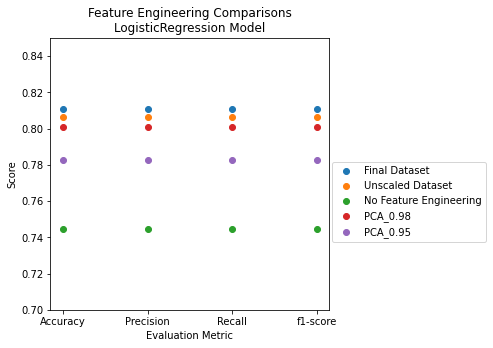

In [105]:
# Visualize Summary Data
plt.figure(figsize=(5,5))
for data_dict in feature_engineerings.values():
    x_plot = data_dict.keys()
    y_plot = data_dict.values()
    plt.scatter(x_plot,y_plot)

plt.legend(feature_engineerings.keys(), loc=(1.01, 0.25))
plt.ylabel("Score")
plt.ylim((0.7,0.85))
plt.xlabel("Evaluation Metric")
plt.title('Feature Engineering Comparisons\nLogisticRegression Model')
plt.show()

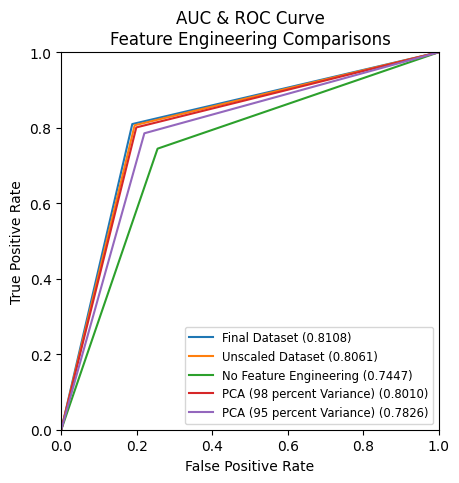

In [106]:
#Final Model
auc_lr = roc_auc_score(y_test, y_pred_lr)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_lr)

# Unscaled Dataset
auc_lr2 = roc_auc_score(y_test, y_pred_lr2)
fpr_lr2, tpr_lr2, _ = roc_curve(y_test, y_pred_lr2)

# No Feature Engineering
auc_lr3 = roc_auc_score(y_test_rand, y_pred_lr3)
fpr_lr3, tpr_lr3, _ = roc_curve(y_test_rand, y_pred_lr3)

# PCA 98% Variance
auc_lr4 = roc_auc_score(y_test, y_pred_pca)
fpr_lr4, tpr_lr4, _ = roc_curve(y_test, y_pred_pca)

# PCA 95% Variance
auc_lr5 = roc_auc_score(y_test, y_pred_pca2)
fpr_lr5, tpr_lr5, _ = roc_curve(y_test, y_pred_pca2)

plt.figure(figsize=(5, 5), dpi=100)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("AUC & ROC Curve\nFeature Engineering Comparisons")
plt.plot(fpr_lr, tpr_lr, label="Final Dataset (%0.4f)"%auc_lr)
plt.plot(fpr_lr2, tpr_lr2, label="Unscaled Dataset (%0.4f)"%auc_lr2)
plt.plot(fpr_lr3, tpr_lr3, label="No Feature Engineering (%0.4f)"%auc_lr3)
plt.plot(fpr_lr4, tpr_lr4, label="PCA (98 percent Variance) (%0.4f)"%auc_lr4)
plt.plot(fpr_lr5, tpr_lr5, label="PCA (95 percent Variance) (%0.4f)"%auc_lr5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(fontsize='small')
plt.show()

### LR 1 - Default

In [107]:
lr = LogisticRegression(solver='lbfgs', max_iter=7600)
lr.fit(X_train_std, y_train)
y_pred_lr = lr.predict(X_test_std)

In [108]:
fpr, tpr, _ = roc_curve(y_test, y_pred_lr)
print(classification_report(y_test, y_pred_lr))
roc_auc_score(y_test, y_pred_lr)

              precision    recall  f1-score   support

           0       0.81      0.81      0.81      2249
           1       0.81      0.81      0.81      2249

    accuracy                           0.81      4498
   macro avg       0.81      0.81      0.81      4498
weighted avg       0.81      0.81      0.81      4498



0.810804802134282

In [109]:
add_model_summary('LogisticRegression_default', y_pred_lr, lr_summaries)

### LR 2 - liblinear with l1 penalty

In [110]:
lr_2 = LogisticRegression(solver='liblinear', penalty='l1', max_iter=7600)
lr_2.fit(X_train_std, y_train)
y_pred_lr_2 = lr_2.predict(X_test_std)

In [111]:
print(classification_report(y_test, y_pred_lr_2))
roc_auc_score(y_test, y_pred_lr_2)

              precision    recall  f1-score   support

           0       0.81      0.81      0.81      2249
           1       0.81      0.81      0.81      2249

    accuracy                           0.81      4498
   macro avg       0.81      0.81      0.81      4498
weighted avg       0.81      0.81      0.81      4498



0.8101378390395731

In [112]:
add_model_summary('LogisticRegression_liblinear_l1', y_pred_lr_2, lr_summaries)

### LR 3 - saga solver with elasticnet penalty

In [113]:
lr_3 = LogisticRegression(solver='saga', penalty='elasticnet', max_iter=7600, l1_ratio = 0.5)
lr_3.fit(X_train_std, y_train)
y_pred_lr_3 = lr_3.predict(X_test_std)

In [114]:
print(classification_report(y_test, y_pred_lr_3))
roc_auc_score(y_test, y_pred_lr_3)

              precision    recall  f1-score   support

           0       0.81      0.81      0.81      2249
           1       0.81      0.81      0.81      2249

    accuracy                           0.81      4498
   macro avg       0.81      0.81      0.81      4498
weighted avg       0.81      0.81      0.81      4498



0.810804802134282

In [115]:
add_model_summary('LogisticRegression_saga_elasticnet', y_pred_lr_3, lr_summaries)

### LR-4 clas weight ='balanced'

In [116]:
lr_4 = LogisticRegression(solver='liblinear', penalty='l1', max_iter=7600, class_weight = 'balanced')
lr_4.fit(X_train_std, y_train)
y_pred_lr_4 = lr_4.predict(X_test_std)

In [117]:
print(classification_report(y_test, y_pred_lr_4))
roc_auc_score(y_test, y_pred_lr_4)

              precision    recall  f1-score   support

           0       0.81      0.81      0.81      2249
           1       0.81      0.81      0.81      2249

    accuracy                           0.81      4498
   macro avg       0.81      0.81      0.81      4498
weighted avg       0.81      0.81      0.81      4498



0.8101378390395731

In [118]:
add_model_summary('LogisticRegression_liblinear_l1_balanced', y_pred_lr_4, lr_summaries)

### LR Comparison

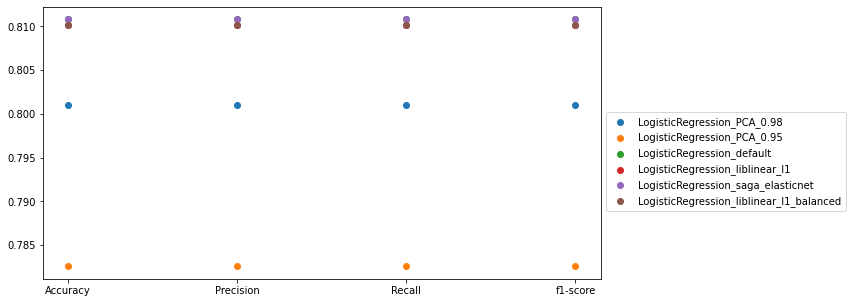

In [119]:
# Visualize Summary Data
plt.figure(figsize=(10,5))
for data_dict in lr_summaries.values():
    x_plot = data_dict.keys()
    y_plot = data_dict.values()
    plt.scatter(x_plot,y_plot)

plt.legend(lr_summaries.keys(), loc=(1.01, 0.25))

In [120]:
# Add preferred model to Overall Comparison
add_model_summary('LogisticRegression', y_pred_lr_2, model_summaries)

## Naive Bayes

In [121]:
gnb = GaussianNB()
gnb.fit(X_train_std,y_train)
y_pred_gnb = gnb.predict(X_test_std)

In [122]:
print(classification_report(y_test, y_pred_gnb))
roc_auc_score(y_test, y_pred_gnb)

              precision    recall  f1-score   support

           0       0.67      0.67      0.67      2249
           1       0.67      0.67      0.67      2249

    accuracy                           0.67      4498
   macro avg       0.67      0.67      0.67      4498
weighted avg       0.67      0.67      0.67      4498



0.6714095153401511

In [123]:
# Add Model Summary to overall comparison
add_model_summary('NaiveBayes', y_pred_gnb, model_summaries)

## Decision Trees

In [124]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train_std, y_train)
y_pred_dtc = dtc.predict(X_test_std)

In [125]:
print(classification_report(y_test, y_pred_dtc))
roc_auc_score(y_test, y_pred_dtc)

              precision    recall  f1-score   support

           0       0.66      0.67      0.67      2249
           1       0.67      0.66      0.66      2249

    accuracy                           0.66      4498
   macro avg       0.66      0.66      0.66      4498
weighted avg       0.66      0.66      0.66      4498



0.6647398843930636

In [126]:
# Add Model Summary to overall comparison
add_model_summary('DecisionTree', y_pred_dtc, model_summaries)

## Random Forest

### Store Optimizations

In [127]:
rf_summaries = {}

### Base Model

In [128]:
rf = RandomForestClassifier(n_estimators=150, max_depth=10, n_jobs=-1, random_state=1)
rf.fit(X_train_std, y_train)

RandomForestClassifier(max_depth=10, n_estimators=150, n_jobs=-1,
                       random_state=1)

In [129]:
y_pred_rf = rf.predict(X_test_std)

print(classification_report(y_test, y_pred_rf))
roc_auc_score(y_test, y_pred_rf)

              precision    recall  f1-score   support

           0       0.81      0.81      0.81      2249
           1       0.81      0.81      0.81      2249

    accuracy                           0.81      4498
   macro avg       0.81      0.81      0.81      4498
weighted avg       0.81      0.81      0.81      4498



0.812361049355269

In [130]:
# Add Model Summary to overall comparison
add_model_summary('RandomForest_base', y_pred_rf, rf_summaries)

### Cross Validation RandomizedSearchCV

In [131]:
rf = RandomForestClassifier()
print(rf.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [132]:
n_estimators = [int(x) for x in np.linspace(100, 1000, 20)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(5, 105, 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
                'max_features': max_features,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf,
                'bootstrap': bootstrap}


In [133]:
if run_hyperparameter_tuning:
    rf = RandomForestClassifier()
    rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                n_iter = 50, cv=3, verbose=2, random_state=42, n_jobs=-1)
    rf_random.fit(X_train_std, y_train)
else:
    pass

In [134]:
# rf_random.best_params_

In [135]:
rf_rscv = RandomForestClassifier(n_estimators=668, max_depth=15, n_jobs=-1, random_state=42,
                                 min_samples_split=2, min_samples_leaf=1, max_features='sqrt',
                                 bootstrap=False)
rf_rscv.fit(X_train_std, y_train)

RandomForestClassifier(bootstrap=False, max_depth=15, max_features='sqrt',
                       n_estimators=668, n_jobs=-1, random_state=42)

In [136]:
y_pred_rf_rscv = rf_rscv.predict(X_test_std)

print(classification_report(y_test, y_pred_rf_rscv))
roc_auc_score(y_test, y_pred_rf_rscv)

              precision    recall  f1-score   support

           0       0.82      0.82      0.82      2249
           1       0.82      0.82      0.82      2249

    accuracy                           0.82      4498
   macro avg       0.82      0.82      0.82      4498
weighted avg       0.82      0.82      0.82      4498



0.8196976433970654

In [137]:
# Add Model Summary to overall comparison
add_model_summary('RandomForest_RSCV', y_pred_rf_rscv, rf_summaries)

### Grid Search with Cross Validation

In [138]:
param_grid = {'bootstrap':[False],
              'max_depth':[10, 15, 20],
              'max_features':['sqrt'],
              'n_estimators': [625, 650, 675, 700, 725],
              'min_samples_split': [1, 2, 3],
              'min_samples_leaf': [1, 2, 3]}

rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

In [139]:
if run_hyperparameter_tuning:
    grid_search.fit(X_train_std, y_train)
else:
    pass

In [140]:
# grid_search.best_params_

In [141]:
rf_gs = RandomForestClassifier(n_estimators=625, max_depth=15, n_jobs=-1, random_state=42,
                                 min_samples_split=3, min_samples_leaf=3, max_features='sqrt',
                                 bootstrap=False)
rf_gs.fit(X_train_std, y_train)

RandomForestClassifier(bootstrap=False, max_depth=15, max_features='sqrt',
                       min_samples_leaf=3, min_samples_split=3,
                       n_estimators=625, n_jobs=-1, random_state=42)

In [142]:
y_pred_rf_gs = rf_gs.predict(X_test_std)

print(classification_report(y_test, y_pred_rf_gs))
roc_auc_score(y_test, y_pred_rf_gs)

              precision    recall  f1-score   support

           0       0.82      0.82      0.82      2249
           1       0.82      0.82      0.82      2249

    accuracy                           0.82      4498
   macro avg       0.82      0.82      0.82      4498
weighted avg       0.82      0.82      0.82      4498



0.8194753223654958

In [143]:
# Add Model Summary to overall comparison
add_model_summary('RandomForest_GSCV', y_pred_rf_gs, rf_summaries)

### Random Forest Comparisons

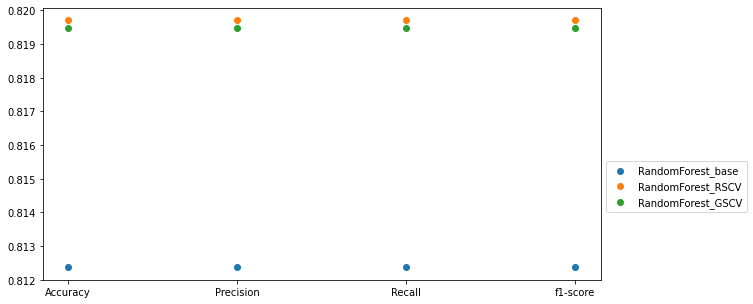

In [144]:
# Visualize Summary Data
plt.figure(figsize=(10,5))
for data_dict in rf_summaries.values():
    x_plot = data_dict.keys()
    y_plot = data_dict.values()
    plt.scatter(x_plot,y_plot)

plt.legend(rf_summaries.keys(), loc=(1.01, 0.25))

In [145]:
# Add Model Summary to overall comparison
add_model_summary('RandomForest', y_pred_rf_gs, model_summaries)

## Bagged Decision Trees

### Store Optimization Data

In [146]:
bc_summaries = {}

### Default Bagged Decision Tree

In [147]:
bc = BaggingClassifier()
bc.fit(X_train_std, y_train)

BaggingClassifier()

In [148]:
y_pred_bc = bc.predict(X_test_std)

print(classification_report(y_test, y_pred_bc))
roc_auc_score(y_test, y_pred_bc)

              precision    recall  f1-score   support

           0       0.74      0.80      0.77      2249
           1       0.78      0.72      0.75      2249

    accuracy                           0.76      4498
   macro avg       0.76      0.76      0.76      4498
weighted avg       0.76      0.76      0.76      4498



0.7610048910626945

In [149]:
# Add Model Summary to overall comparison
add_model_summary('Unoptimized', y_pred_bc, bc_summaries)

### Randomized Search CV

In [150]:
# Random grid to test for RSCV
random_grid = {'n_estimators': [800, 1000, 1200],
                'max_samples': [0.25, 0.5, 0.75, 1],
                'max_features': [0.25, 0.5, 0.75, 1],
                'bootstrap': [True, False],
                'bootstrap_features': [True, False]}

In [151]:
if run_hyperparameter_tuning:
    bc = BaggingClassifier()
    bc_cv = RandomizedSearchCV(estimator=bc, param_distributions=random_grid, n_iter=50, cv=3,
                                verbose=2, random_state=42, n_jobs=-1)
    bc_cv.fit(X_train_std, y_train)
    bc_cv.best_params_
else:
    pass

In [152]:
best_params_search1 = {'n_estimators': 1000,
 'max_samples': 0.25,
 'max_features': 0.75,
 'bootstrap_features': False,
 'bootstrap': False}

In [153]:
bc_cv_best = BaggingClassifier(n_estimators=750, max_samples=0.25,
                          max_features=0.6, bootstrap_features=False,
                          bootstrap=False)
bc_cv_best.fit(X_train_std, y_train)

BaggingClassifier(bootstrap=False, max_features=0.6, max_samples=0.25,
                  n_estimators=750)

In [154]:
y_pred_bc_cv = bc_cv_best.predict(X_test_std)


print(classification_report(y_test, y_pred_bc_cv))
roc_auc_score(y_test, y_pred_bc_cv)

              precision    recall  f1-score   support

           0       0.82      0.82      0.82      2249
           1       0.82      0.82      0.82      2249

    accuracy                           0.82      4498
   macro avg       0.82      0.82      0.82      4498
weighted avg       0.82      0.82      0.82      4498



0.8159181858603824

In [155]:
# Add Model Summary to overall comparison
add_model_summary('RandomizedSearchCV', y_pred_bc_cv, bc_summaries)

### Grid Search

In [156]:
param_grid = {'bootstrap':[False],
              'max_samples':[0.25, 0.375, 0.5],
              'max_features':[0.6, 0.8],
              'n_estimators': [750, 1000, 1250],
              'bootstrap_features': [False],}

bc_gs = BaggingClassifier()
grid_search = GridSearchCV(estimator=bc_gs, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

In [157]:
if run_hyperparameter_tuning:
    grid_search.fit(X_train_std,y_train)
    grid_search.best_params_
else:
    pass

In [158]:
# Test with grid search parameters
bc_gscv = BaggingClassifier(n_estimators=1000, max_samples=0.25,
                          max_features=0.75, bootstrap_features=False,
                          bootstrap=False)
bc_gscv.fit(X_train_std, y_train)

BaggingClassifier(bootstrap=False, max_features=0.75, max_samples=0.25,
                  n_estimators=1000)

In [159]:
y_pred_bc_gscv = bc_gscv.predict(X_test_std)


print(classification_report(y_test, y_pred_bc_gscv))
roc_auc_score(y_test, y_pred_bc_gscv)

              precision    recall  f1-score   support

           0       0.83      0.82      0.83      2249
           1       0.82      0.83      0.83      2249

    accuracy                           0.83      4498
   macro avg       0.83      0.83      0.83      4498
weighted avg       0.83      0.83      0.83      4498



0.8254779902178746

In [170]:
# Add Model Summary to overall comparison
add_model_summary('GridSearchCV', y_pred_bc_gscv, bc_summaries)

### Compare Models

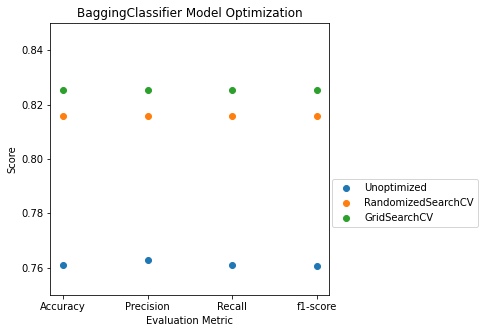

In [171]:
# Visualize Summary Data
plt.figure(figsize=(5,5))
for data_dict in bc_summaries.values():
    x_plot = data_dict.keys()
    y_plot = data_dict.values()
    plt.scatter(x_plot,y_plot)

plt.legend(bc_summaries.keys(), loc=(1.01, 0.25))
plt.ylabel("Score")
plt.ylim((0.75,0.85))
plt.xlabel("Evaluation Metric")
plt.title('BaggingClassifier Model Optimization')
plt.show()

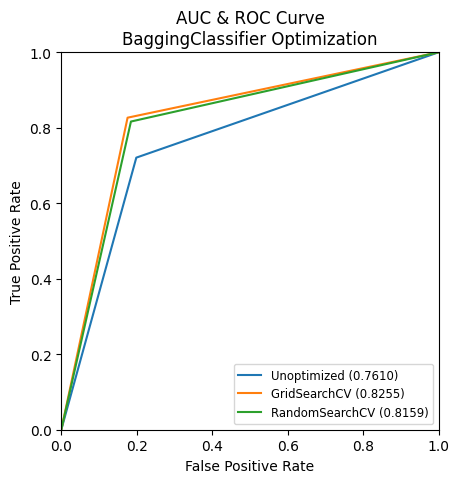

In [172]:
# Baseline model
auc_basic = roc_auc_score(y_test, y_pred_bc)
fpr_basic, tpr_basic, _ = roc_curve(y_test, y_pred_bc)

# GridSearchCV
auc_bc = roc_auc_score(y_test, y_pred_bc_gscv)
fpr_bc, tpr_bc, _ = roc_curve(y_test, y_pred_bc_gscv)

# RandomSearchCV
auc_bc2 = roc_auc_score(y_test, y_pred_bc_cv)
fpr_bc2, tpr_bc2, _ = roc_curve(y_test, y_pred_bc_cv)

plt.figure(figsize=(5, 5), dpi=100)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("AUC & ROC Curve\nBaggingClassifier Optimization")
plt.plot(fpr_basic, tpr_basic, label='Unoptimized (%0.4f)'%auc_basic)
plt.plot(fpr_bc, tpr_bc, label="GridSearchCV (%0.4f)"%auc_bc)
plt.plot(fpr_bc2, tpr_bc2, label="RandomSearchCV (%0.4f)"%auc_bc2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(fontsize='small')
plt.show()

In [173]:
# Add Model Summary to overall comparison
add_model_summary('BaggingClassifier', y_pred_bc_gscv, model_summaries)

### Confusion Matrix

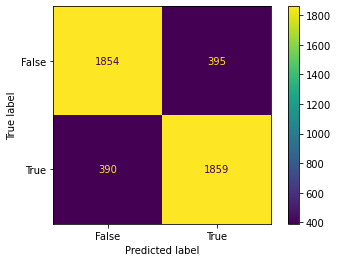

In [174]:
conf_matrix_bc = confusion_matrix(y_test, y_pred_bc_gscv)
cm_viz = ConfusionMatrixDisplay(confusion_matrix = conf_matrix_bc,
        display_labels = [False, True])
cm_viz.plot()
plt.show()

## Stochastic Gradient Descent

In [175]:
sgd = SGDClassifier(loss='log', penalty='none')
sgd.fit(X_train_std, y_train)
y_pred_sgd = sgd.predict(X_test_std)

print(classification_report(y_test, y_pred_sgd))
roc_auc_score(y_test, y_pred_sgd)

              precision    recall  f1-score   support

           0       0.79      0.78      0.79      2249
           1       0.79      0.79      0.79      2249

    accuracy                           0.79      4498
   macro avg       0.79      0.79      0.79      4498
weighted avg       0.79      0.79      0.79      4498



0.788128056914184

In [176]:
# Add Model Summary to overall comparison
add_model_summary('SGDClassifier', y_pred_sgd, model_summaries)

## GradientBoostingClassifier

In [177]:
from sklearn.ensemble import GradientBoostingClassifier

In [178]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train_std, y_train)
y_pred_gbc = gbc.predict(X_test_std)

In [179]:
gbc.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [180]:
print(classification_report(y_test, y_pred_gbc))
roc_auc_score(y_test, y_pred_gbc)

              precision    recall  f1-score   support

           0       0.83      0.83      0.83      2249
           1       0.83      0.83      0.83      2249

    accuracy                           0.83      4498
   macro avg       0.83      0.83      0.83      4498
weighted avg       0.83      0.83      0.83      4498



0.8252556691863049

In [181]:
param_grid = {'min_samples_split': [2, 8, 80],
            'min_samples_leaf': [1, 5, 50],
            'max_depth': [3, 5, 8],
            'max_features': ['sqrt', None],
            'n_estimators': [40, 80, 120]}
gbc = GradientBoostingClassifier()
grid_search = GridSearchCV(estimator=gbc, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

In [182]:
if run_hyperparameter_tuning:
    grid_search.fit(X_train_std, y_train)
    grid_search.best_params_
else:
    pass

In [183]:
gbc_gs = GradientBoostingClassifier(max_depth=5, max_features='sqrt', min_samples_leaf=50, 
            min_samples_split = 40, n_estimators = 40)
gbc_gs.fit(X_train_std, y_train)

GradientBoostingClassifier(max_depth=5, max_features='sqrt',
                           min_samples_leaf=50, min_samples_split=40,
                           n_estimators=40)

In [184]:
y_pred_gbc_gs = gbc_gs.predict(X_test_std)

print(classification_report(y_test, y_pred_gbc_gs))
roc_auc_score(y_test, y_pred_gbc_gs)

              precision    recall  f1-score   support

           0       0.81      0.81      0.81      2249
           1       0.81      0.82      0.81      2249

    accuracy                           0.81      4498
   macro avg       0.81      0.81      0.81      4498
weighted avg       0.81      0.81      0.81      4498



0.8128056914184081

In [185]:
add_model_summary('Boosting Classifier', y_pred_gbc, model_summaries)

## CNN

In [186]:
# Convert arrays to float type
X_train_cnn = np.asarray(X_train_std).astype('float32')
X_test_cnn = np.asarray(X_test_std).astype('float32')
y_train_cnn = np.asarray(y_train).astype('float32')
y_test_cnn = np.asarray(y_test).astype('float32')

# Expand X dim to [Rows, features, 1, 1]
X_train_cnn = np.expand_dims(X_train_cnn, axis=2)
X_train_cnn = np.expand_dims(X_train_cnn, axis=3)
X_test_cnn = np.expand_dims(X_test_cnn, axis=2)
X_test_cnn = np.expand_dims(X_test_cnn, axis=3)

In [187]:
cnn = tf.keras.Sequential()

# add first convolution layer to the model
cnn.add(tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=(5,5),
    strides=(1,1),
    padding='same',
    data_format='channels_last',
    name='conv_1',
    activation='relu'))

# add second convolutional layer
cnn.add(tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=(5,5),
    strides=(1,1),
    padding='same',
    name='conv_2',
    activation='relu'))


# add a fully connected layer (need to flatten the output of the previous layers first)
cnn.add(tf.keras.layers.Flatten()) 
cnn.add(tf.keras.layers.Dense(
    units=1024,
    name='fc_1', 
    activation='relu'))

# add dropout layer
cnn.add(tf.keras.layers.Dropout(
    rate=0.5))

# add the last fully connected layer
# this last layer sets the activation function to "None" in order to output the logits 
# note that passing activation = "sigmoid" will return class memembership probabilities but
# in TensorFlow logits are prefered for numerical stability
# set units=1 to get a single output unit (remember it's a binary classification problem)
cnn.add(tf.keras.layers.Dense(
    units=1,
    name='fc_2',
    activation=None))

# build model and print summary
tf.random.set_seed(1)
cnn.build(input_shape=(None, 149, 1, 1))
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 149, 1, 32)        832       
                                                                 
 conv_2 (Conv2D)             (None, 149, 1, 32)        25632     
                                                                 
 flatten (Flatten)           (None, 4768)              0         
                                                                 
 fc_1 (Dense)                (None, 1024)              4883456   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 fc_2 (Dense)                (None, 1)                 1025      
                                                                 
Total params: 4,910,945
Trainable params: 4,910,945
No

In [188]:
cnn.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), #set from_ligits=True because our last layer does not apply sigmoid
              metrics=['accuracy']) 

In [189]:
cnn.fit(X_train_cnn, y_train_cnn, validation_data=None, epochs=5)

Epoch 1/5
690/690 [==============================] - 25s 35ms/step - loss: 0.5652 - accuracy: 0.6909
Epoch 2/5
690/690 [==============================] - 23s 33ms/step - loss: 0.5334 - accuracy: 0.7200
Epoch 3/5
690/690 [==============================] - 23s 34ms/step - loss: 0.5189 - accuracy: 0.7316
Epoch 4/5
690/690 [==============================] - 23s 34ms/step - loss: 0.5020 - accuracy: 0.7404
Epoch 5/5
690/690 [==============================] - 24s 34ms/step - loss: 0.4806 - accuracy: 0.7540


In [190]:
# transform logits to probabilities
y_pred_cnn_raw = cnn.predict(X_test_cnn)
y_pred_cnn = tf.sigmoid(y_pred_cnn_raw)
y_pred_cnn = np.where(y_pred_cnn >= 0.5, 1, 0)

141/141 [==============================] - 1s 7ms/step


In [191]:
print(classification_report(y_test_cnn,y_pred_cnn))
roc_auc_score(y_test_cnn, y_pred_cnn)

              precision    recall  f1-score   support

         0.0       0.81      0.79      0.80      2249
         1.0       0.79      0.81      0.80      2249

    accuracy                           0.80      4498
   macro avg       0.80      0.80      0.80      4498
weighted avg       0.80      0.80      0.80      4498



0.8012449977767897

In [192]:
add_model_summary('Convolutional Neural Network', y_pred_cnn, model_summaries)

# Model Summaries

### Ensemble Model Comparisons

In [193]:
ensemble_summaries = {}
add_model_summary("Single Decision Tree", y_pred_dtc, ensemble_summaries)
add_model_summary("Random Forest Classifier", y_pred_rf_rscv, ensemble_summaries)
add_model_summary("Bagged Decision Tree Classifier", y_pred_bc_gscv, ensemble_summaries)
add_model_summary("Boosted Decision Tree Classifier", y_pred_gbc, ensemble_summaries)

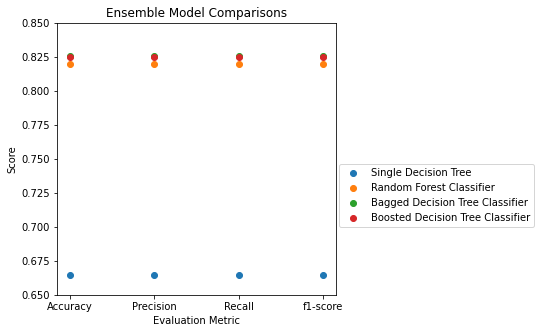

In [194]:
# Visualize Summary Data
plt.figure(figsize=(5,5))
for data_dict in ensemble_summaries.values():
    x_plot = data_dict.keys()
    y_plot = data_dict.values()
    plt.scatter(x_plot,y_plot)

plt.legend(ensemble_summaries.keys(), loc=(1.01, 0.25))
plt.ylabel("Score")
plt.ylim((0.65,0.85))
plt.xlabel("Evaluation Metric")
plt.title('Ensemble Model Comparisons')
plt.show()

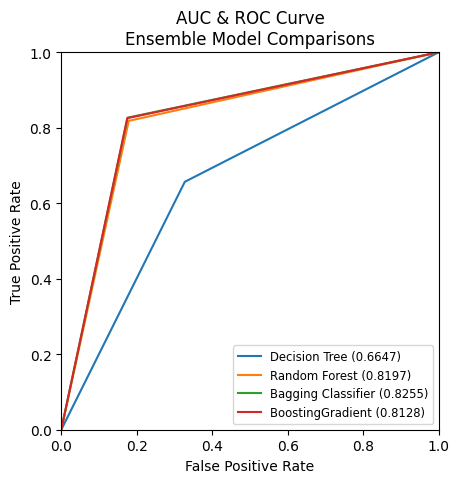

In [195]:
#Decision Tree
auc_dtc = roc_auc_score(y_test, y_pred_dtc)
fpr_dtc, tpr_dtc, _ = roc_curve(y_test, y_pred_dtc)

# Random Forest
auc_rf = roc_auc_score(y_test, y_pred_rf_rscv)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf_rscv)

# Bagging Classifier
auc_bc = roc_auc_score(y_test, y_pred_bc_gscv)
fpr_bc, tpr_bc, _ = roc_curve(y_test, y_pred_bc_gscv)

# Gradient Boosting Classifier
auc_gbc = roc_auc_score(y_test, y_pred_gbc_gs)
fpr_gbc, tpr_gbc, _ = roc_curve(y_test, y_pred_gbc)


plt.figure(figsize=(5, 5), dpi=100)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("AUC & ROC Curve\nEnsemble Model Comparisons")
plt.plot(fpr_dtc, tpr_dtc, label="Decision Tree (%0.4f)"%auc_dtc)
plt.plot(fpr_rf, tpr_rf, label="Random Forest (%0.4f)"%auc_rf)
plt.plot(fpr_bc, tpr_bc, label="Bagging Classifier (%0.4f)"%auc_bc)
plt.plot(fpr_gbc, tpr_gbc, label="BoostingGradient (%0.4f)"%auc_gbc)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(fontsize='small')
plt.show()

### All Model Comparisons

In [196]:
model_summaries

{'Baseline': {'Accuracy': 0.5813694975544687,
  'Precision': 0.5813696423402804,
  'Recall': 0.5813694975544688,
  'f1-score': 0.5813693113308895},
 'Keras_Sequential': {'Accuracy': 0.7899066251667408,
  'Precision': 0.7901062811107681,
  'Recall': 0.7899066251667408,
  'f1-score': 0.7898704715119338},
 'Neural_Network': {'Accuracy': 0.8008003557136505,
  'Precision': 0.802254619645924,
  'Recall': 0.8008003557136505,
  'f1-score': 0.8005604605142959},
 'LogisticRegression': {'Accuracy': 0.8101378390395731,
  'Precision': 0.8101417633315717,
  'Recall': 0.8101378390395731,
  'f1-score': 0.8101372384457446},
 'NaiveBayes': {'Accuracy': 0.6714095153401511,
  'Precision': 0.6714096508954038,
  'Recall': 0.6714095153401511,
  'f1-score': 0.6714094503756426},
 'DecisionTree': {'Accuracy': 0.6647398843930635,
  'Precision': 0.6647821061343305,
  'Recall': 0.6647398843930635,
  'f1-score': 0.6647184072846092},
 'RandomForest': {'Accuracy': 0.8194753223654958,
  'Precision': 0.819477596226941,

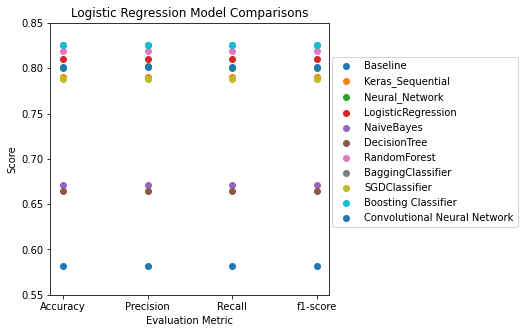

In [197]:
# Visualize Summary Data
plt.figure(figsize=(5,5))
for data_dict in model_summaries.values():
    x_plot = data_dict.keys()
    y_plot = data_dict.values()
    plt.scatter(x_plot,y_plot)

plt.legend(model_summaries.keys(), loc=(1.01, 0.25))
plt.ylabel("Score")
plt.ylim((0.55,0.85))
plt.xlabel("Evaluation Metric")
plt.title('Logistic Regression Model Comparisons')
plt.show()


### Best Model Comparisons

In [198]:
best_models = {}

for data_dict, model in zip(model_summaries.values(), model_summaries.keys()):
    if data_dict['Accuracy'] > 0.7:
        best_models[model] = data_dict

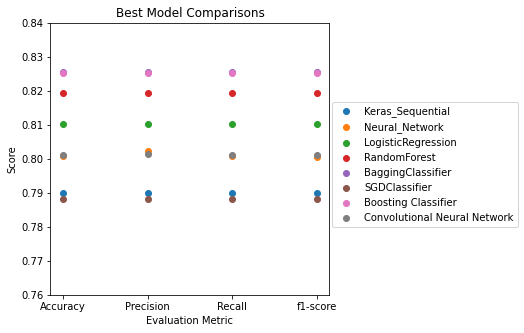

In [199]:
# Visualize Summary Data
plt.figure(figsize=(5,5))
for data_dict in best_models.values():
    x_plot = data_dict.keys()
    y_plot = data_dict.values()
    plt.scatter(x_plot,y_plot)

plt.legend(best_models.keys(), loc=(1.01, 0.25))
plt.ylabel("Score")
plt.ylim((0.76,0.84))
plt.xlabel("Evaluation Metric")
plt.title('Best Model Comparisons')
plt.show()

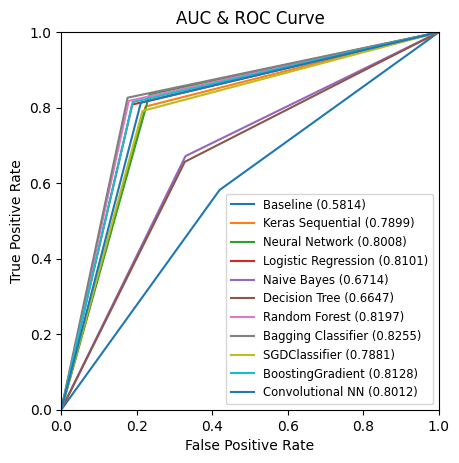

In [200]:
# Baseline model
auc_base = roc_auc_score(y_test, y_pred_baseline)
fpr_base, tpr_base, _ = roc_curve(y_test, y_pred_baseline)

# Keras_Sequential Model
auc_ks = roc_auc_score(y_test, y_pred_ks)
fpr_ks, tpr_ks, _ = roc_curve(y_test, y_pred_ks)

# NN Model
auc_nn = roc_auc_score(y_test, y_pred_nn)
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_pred_nn)

# NN Model
auc_lr = roc_auc_score(y_test, y_pred_lr_2)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_lr_2)

# Naive Bayes Model
auc_gnb = roc_auc_score(y_test, y_pred_gnb)
fpr_gnb, tpr_gnb, _ = roc_curve(y_test, y_pred_gnb)

#Decision Tree
auc_dtc = roc_auc_score(y_test, y_pred_dtc)
fpr_dtc, tpr_dtc, _ = roc_curve(y_test, y_pred_dtc)

# Random Forest
auc_rf = roc_auc_score(y_test, y_pred_rf_rscv)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf_rscv)

# Bagging Classifier
auc_bc = roc_auc_score(y_test, y_pred_bc_gscv)
fpr_bc, tpr_bc, _ = roc_curve(y_test, y_pred_bc_gscv)

# SGDClassifier
auc_sgd = roc_auc_score(y_test, y_pred_sgd)
fpr_sgd, tpr_sgd, _ = roc_curve(y_test, y_pred_sgd)

# Gradient Boosting Classifier
auc_gbc = roc_auc_score(y_test, y_pred_gbc_gs)
fpr_gbc, tpr_gbc, _ = roc_curve(y_test, y_pred_gbc_gs)

# Gradient Boosting Classifier
auc_cnn = roc_auc_score(y_test, y_pred_cnn)
fpr_cnn, tpr_cnn, _ = roc_curve(y_test, y_pred_cnn)

plt.figure(figsize=(5, 5), dpi=100)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("AUC & ROC Curve")
plt.plot(fpr_base, tpr_base, label='Baseline (%0.4f)'%auc_base)
plt.plot(fpr_ks, tpr_ks, label="Keras Sequential (%0.4f)"%auc_ks)
plt.plot(fpr_nn, tpr_nn, label="Neural Network (%0.4f)"%auc_nn)
plt.plot(fpr_lr, tpr_lr, label="Logistic Regression (%0.4f)"%auc_lr)
plt.plot(fpr_gnb, tpr_gnb, label="Naive Bayes (%0.4f)"%auc_gnb)
plt.plot(fpr_dtc, tpr_dtc, label="Decision Tree (%0.4f)"%auc_dtc)
plt.plot(fpr_rf, tpr_rf, label="Random Forest (%0.4f)"%auc_rf)
plt.plot(fpr_bc, tpr_bc, label="Bagging Classifier (%0.4f)"%auc_bc)
plt.plot(fpr_sgd, tpr_sgd, label="SGDClassifier (%0.4f)"%auc_sgd)
plt.plot(fpr_gbc, tpr_gbc, label="BoostingGradient (%0.4f)"%auc_gbc)
plt.plot(fpr_cnn, tpr_cnn, label="Convolutional NN (%0.4f)"%auc_cnn)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(fontsize='small')
plt.show()

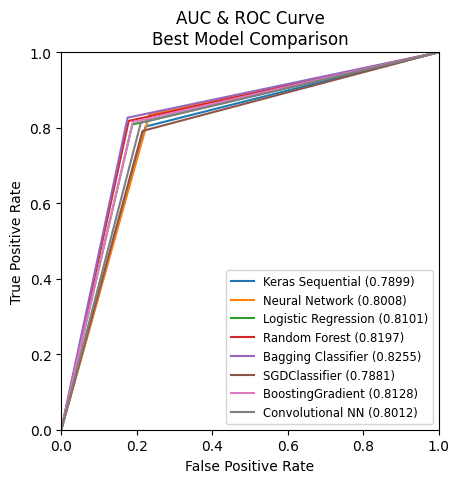

In [201]:
# Keras_Sequential Model
auc_ks = roc_auc_score(y_test, y_pred_ks)
fpr_ks, tpr_ks, _ = roc_curve(y_test, y_pred_ks)

# NN Model
auc_nn = roc_auc_score(y_test, y_pred_nn)
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_pred_nn)

# LR Model
auc_lr = roc_auc_score(y_test, y_pred_lr_2)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_lr_2)

# Random Forest
auc_rf = roc_auc_score(y_test, y_pred_rf_rscv)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf_rscv)

# Bagging Classifier
auc_bc = roc_auc_score(y_test, y_pred_bc_gscv)
fpr_bc, tpr_bc, _ = roc_curve(y_test, y_pred_bc_gscv)

# SGDClassifier
auc_sgd = roc_auc_score(y_test, y_pred_sgd)
fpr_sgd, tpr_sgd, _ = roc_curve(y_test, y_pred_sgd)

# Gradient Boosting Classifier
auc_gbc = roc_auc_score(y_test, y_pred_gbc_gs)
fpr_gbc, tpr_gbc, _ = roc_curve(y_test, y_pred_gbc_gs)

# CNN Classifier
auc_cnn = roc_auc_score(y_test, y_pred_cnn)
fpr_cnn, tpr_cnn, _ = roc_curve(y_test, y_pred_cnn)

plt.figure(figsize=(5, 5), dpi=100)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("AUC & ROC Curve\nBest Model Comparison")
plt.plot(fpr_ks, tpr_ks, label="Keras Sequential (%0.4f)"%auc_ks)
plt.plot(fpr_nn, tpr_nn, label="Neural Network (%0.4f)"%auc_nn)
plt.plot(fpr_lr, tpr_lr, label="Logistic Regression (%0.4f)"%auc_lr)
plt.plot(fpr_rf, tpr_rf, label="Random Forest (%0.4f)"%auc_rf)
plt.plot(fpr_bc, tpr_bc, label="Bagging Classifier (%0.4f)"%auc_bc)
plt.plot(fpr_sgd, tpr_sgd, label="SGDClassifier (%0.4f)"%auc_sgd)
plt.plot(fpr_gbc, tpr_gbc, label="BoostingGradient (%0.4f)"%auc_gbc)
plt.plot(fpr_cnn, tpr_cnn, label="Convolutional NN (%0.4f)"%auc_cnn)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(fontsize='small')
plt.show()

# EDA Visualization

In [202]:
sn.set_style("darkgrid")

[Text(0, 0, 'Loss'), Text(1, 0, 'Win')]

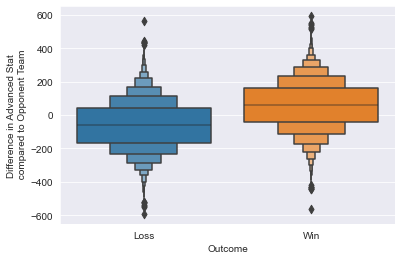

In [203]:
df_viz = df_full_f6[['outcome', 'elo1_pre', 'elo2_pre']]
df_viz['elo_differential'] = df_viz.elo1_pre - df_viz.elo2_pre
ax = sn.boxenplot(data=df_viz, y='elo_differential', x='outcome')
ax.set(xlabel='Outcome', ylabel='Difference in Advanced Stat\n compared to Opponent Team')
ax.set_xticks([0,1])
ax.set_xticklabels(['Loss', 'Win'])

[Text(0, 0, 'Loss'), Text(1, 0, 'Win')]

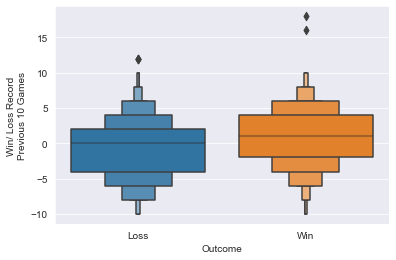

In [204]:
df_viz = df_full_f6[['outcome', 'W_team1_l10', 'L_team1_l10']]
df_viz['Last_10_Games'] = df_viz.W_team1_l10 - df_viz.L_team1_l10
ax = sn.boxenplot(data=df_viz, y='Last_10_Games', x='outcome')
ax.set(xlabel='Outcome', ylabel='Win/ Loss Record\nPrevious 10 Games')
ax.set_xticks([0,1])
ax.set_xticklabels(['Loss', 'Win'])

[Text(0, 0, 'Loss'), Text(1, 0, 'Win')]

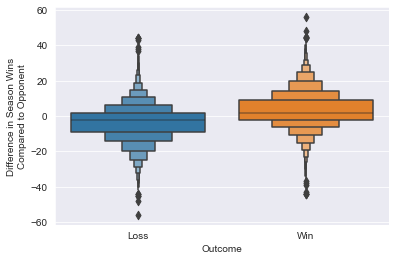

In [205]:
df_viz = df_full_f6[['outcome', 'W_team1', 'W_team2']]
df_viz['win_differential'] = df_viz.W_team1 - df_viz.W_team2
ax = sn.boxenplot(data=df_viz, y='win_differential', x='outcome')
ax.set(xlabel='Outcome', ylabel='Difference in Season Wins\nCompared to Opponent')
ax.set_xticks([0,1])
ax.set_xticklabels(['Loss', 'Win'])

[Text(0, 0, 'Loss'), Text(1, 0, 'Win')]

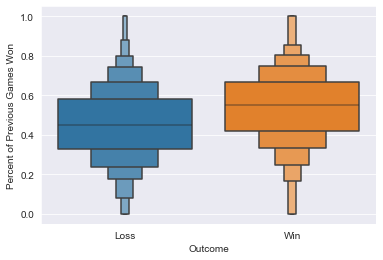

In [206]:
df_viz = df_full_f6[['outcome', 'W_PCT_team1']]
ax = sn.boxenplot(data=df_viz, y='W_PCT_team1', x='outcome')
ax.set(xlabel='Outcome', ylabel='Percent of Previous Games Won')
ax.set_xticks([0,1])
ax.set_xticklabels(['Loss', 'Win'])

[Text(0, 0, 'Loss'), Text(1, 0, 'Win')]

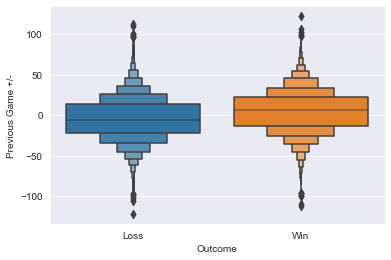

In [207]:
df_viz = df_full_f6[['outcome', 'PLUS_MINUS_team1', 'PLUS_MINUS_team2']]
df_viz['plus_minus_diff'] = df_viz.PLUS_MINUS_team1 - df_viz.PLUS_MINUS_team2
ax = sn.boxenplot(data=df_viz, y='plus_minus_diff', x='outcome')
ax.set(xlabel='Outcome', ylabel='Previous Game +/-')
ax.set_xticks([0,1])
ax.set_xticklabels(['Loss', 'Win'])

